In [168]:
#Import libraries
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
import plotly.express as px
import contextily as cx


#Import palettes
import matplotlib.colors as colors
from palettable.lightbartlein.diverging import BlueOrange10_2_r as palette
from palettable.scientific.diverging import Vik_4_r as palette2
from palettable.lightbartlein.diverging import RedYellowBlue_2 as palette3


# Arrow charts 
## Horizontal and vertical growth

/Users/guilhermeiablonovski/opt/anaconda3/envs/geopandasenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/guilhermeiablonovski/opt/anaconda3/envs/geopandasenv/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars
/Users/guilhermeiablonovski/opt/anaconda3/envs/geopandasenv/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


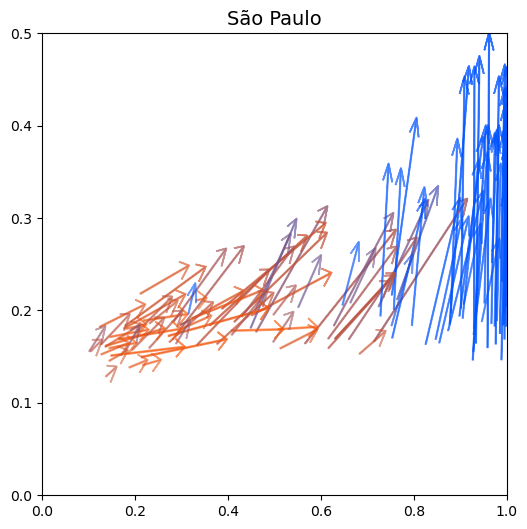

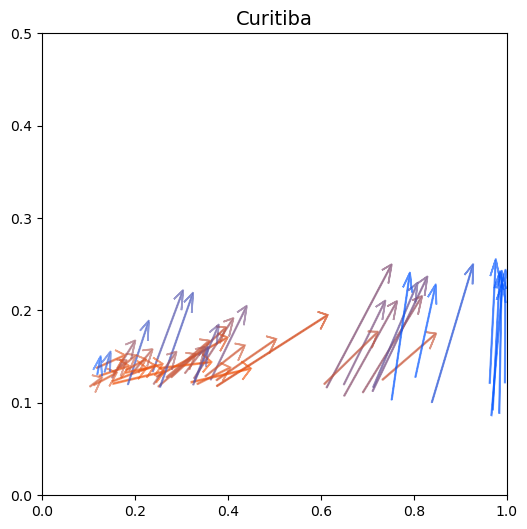

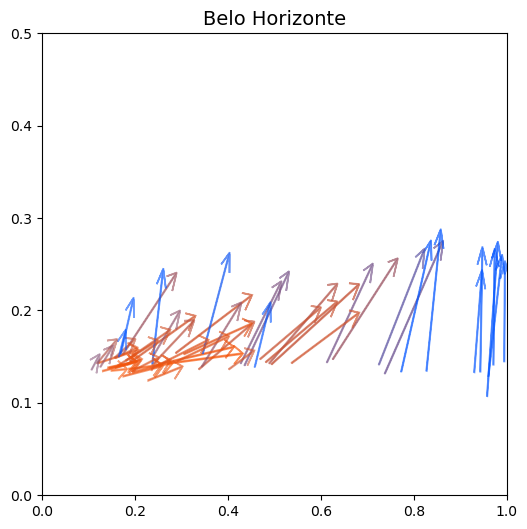

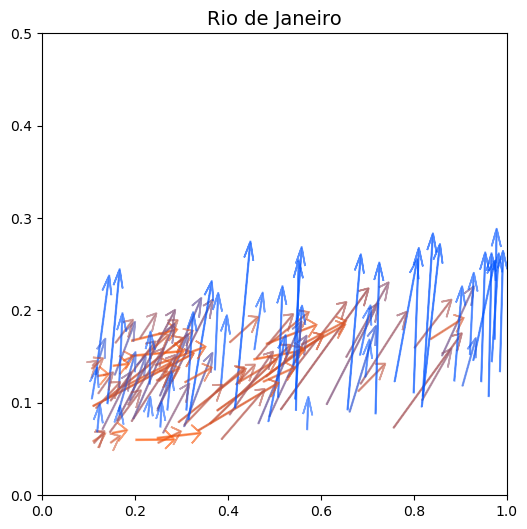

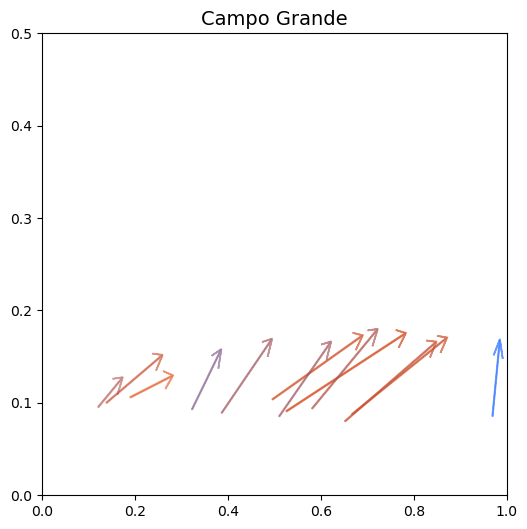

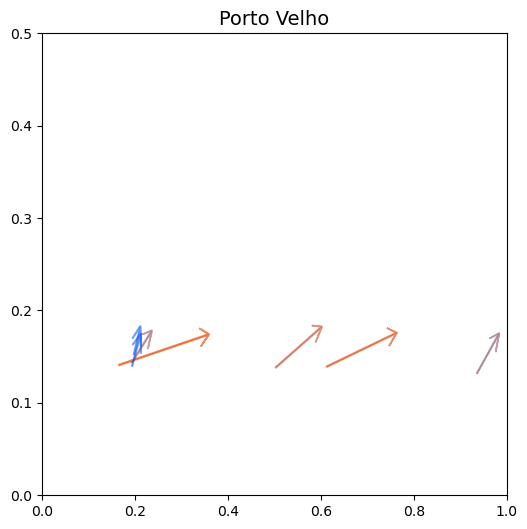

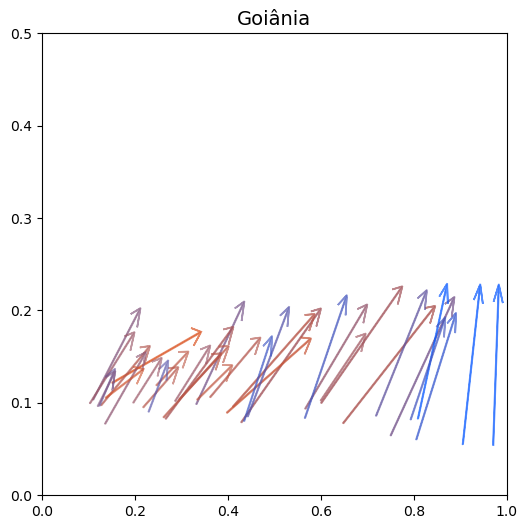

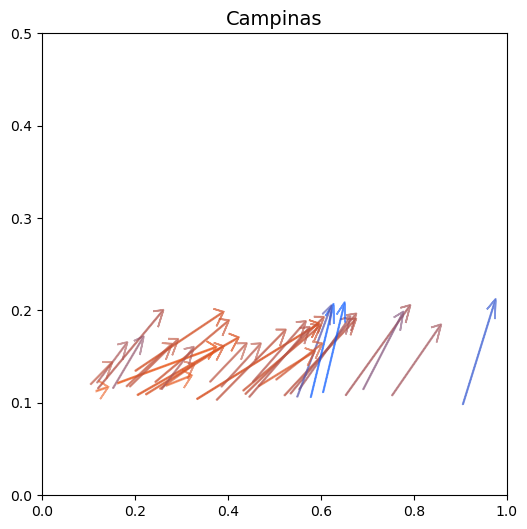

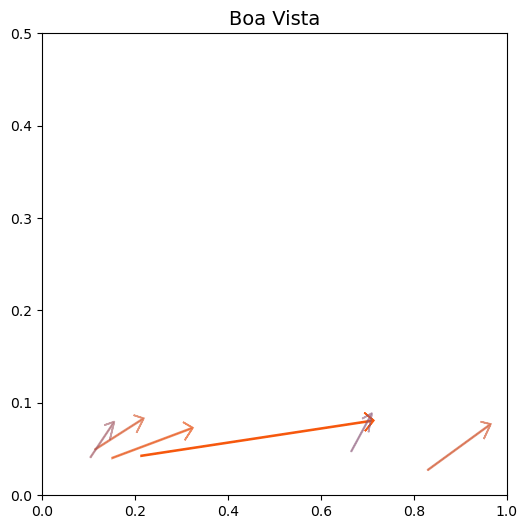

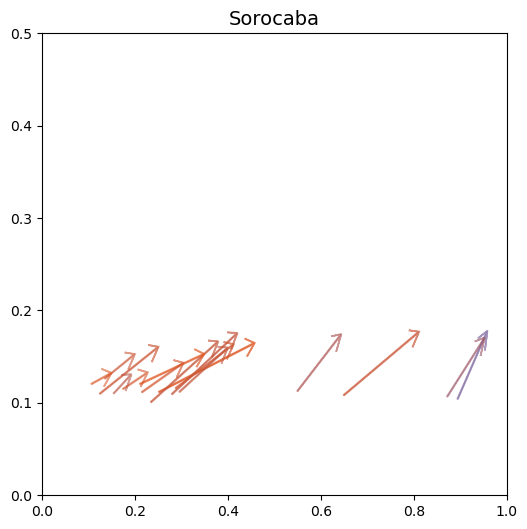

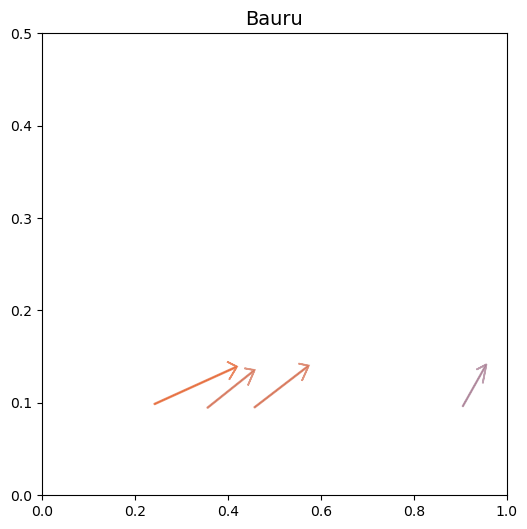

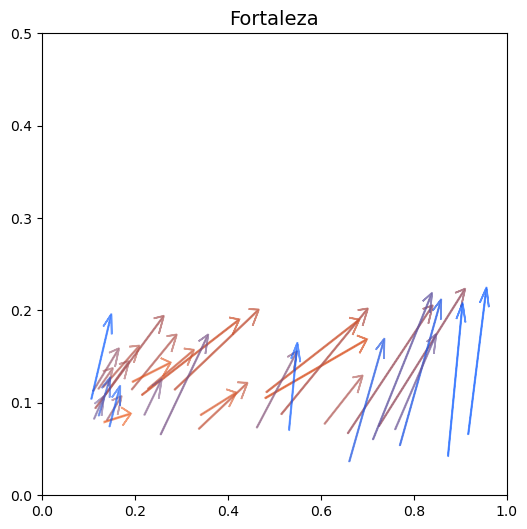

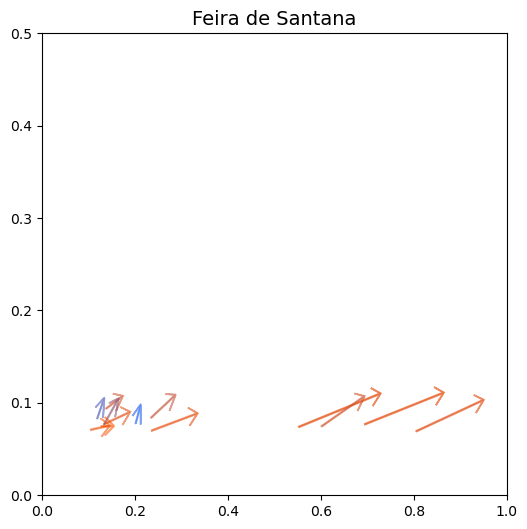

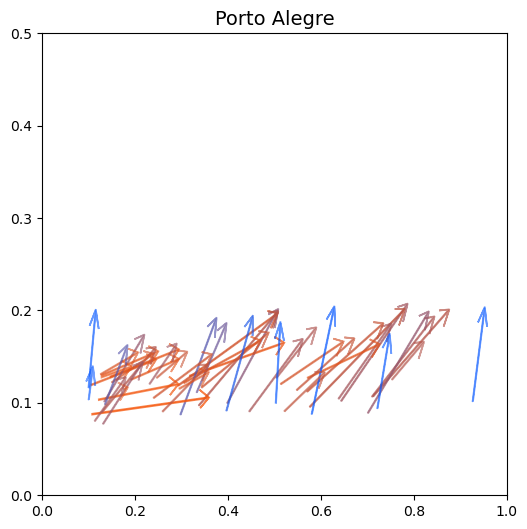

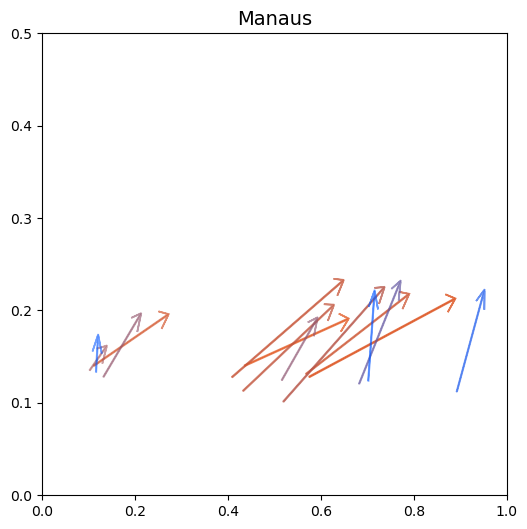

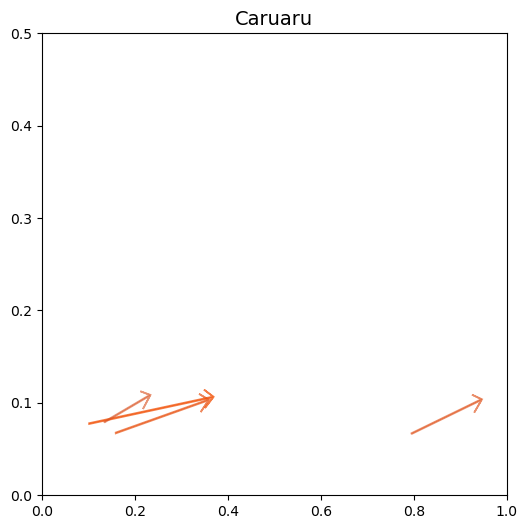

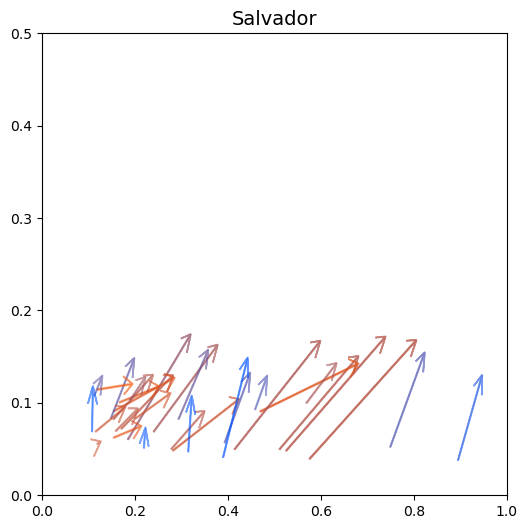

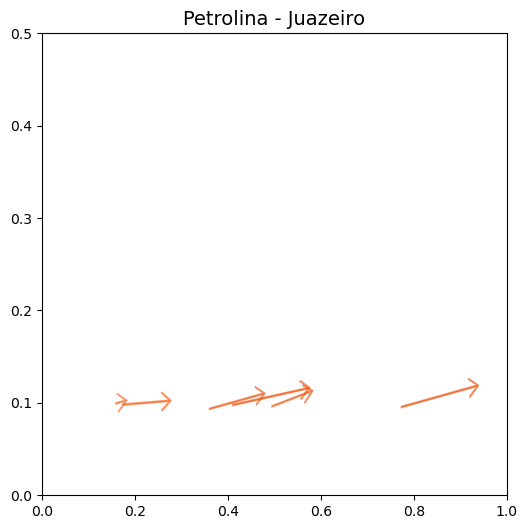

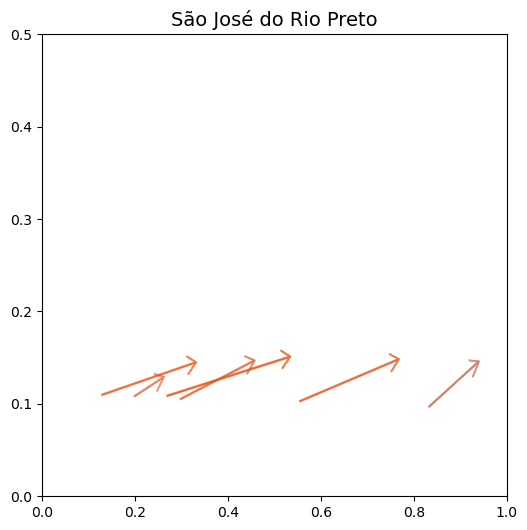

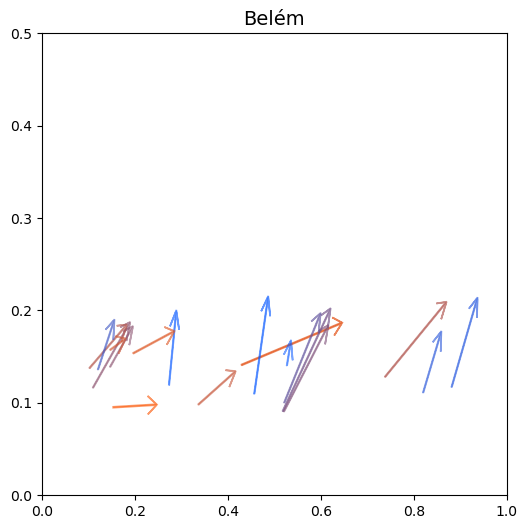

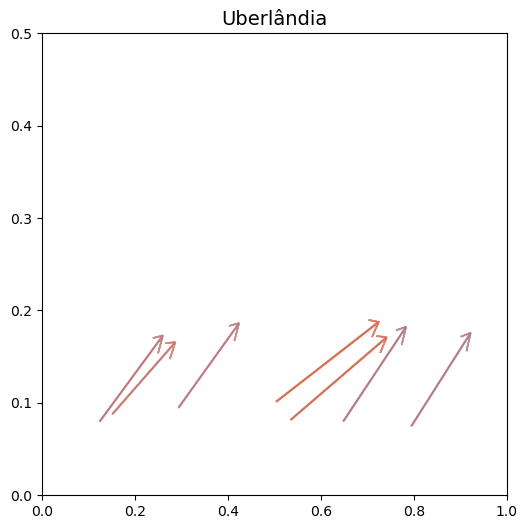

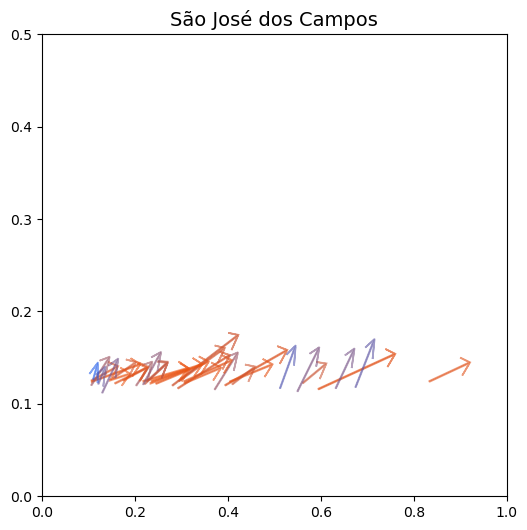

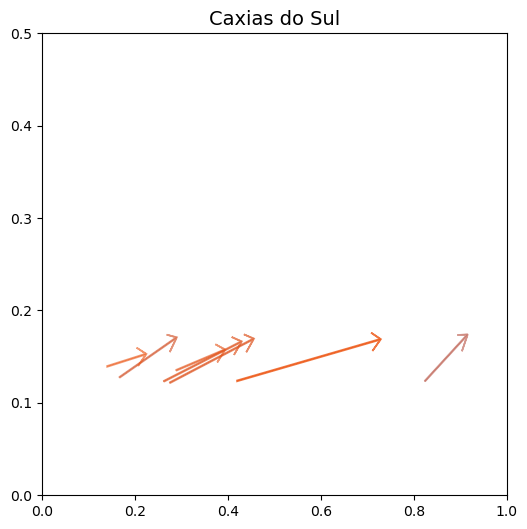

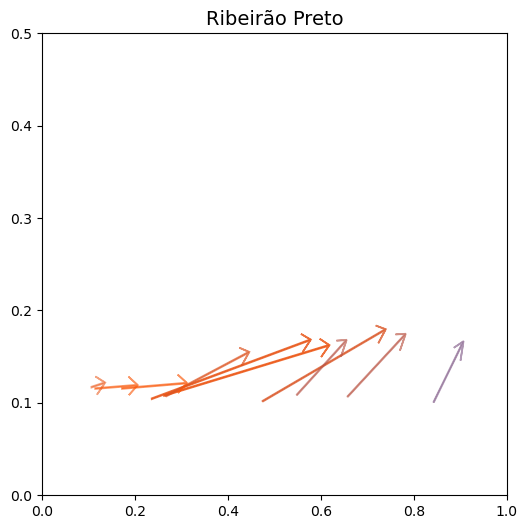

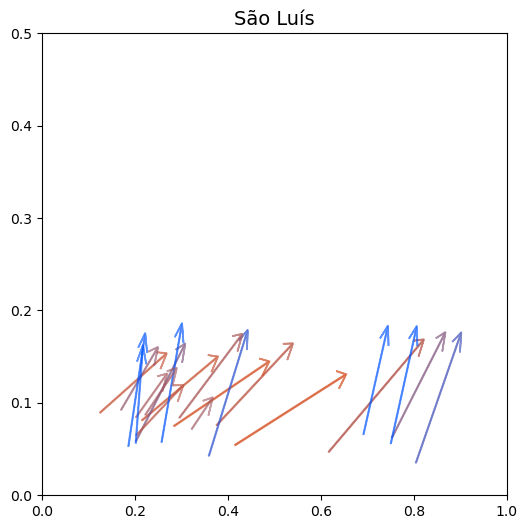

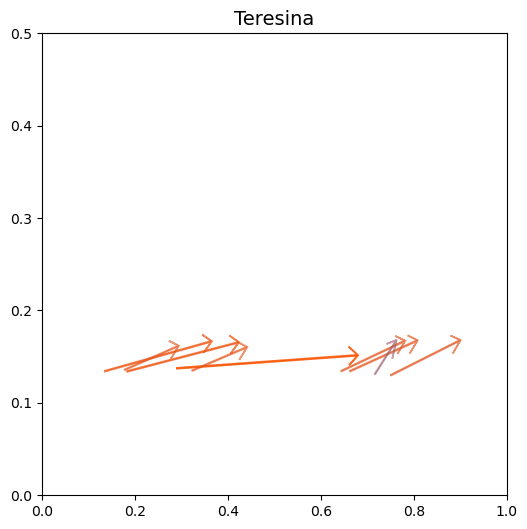

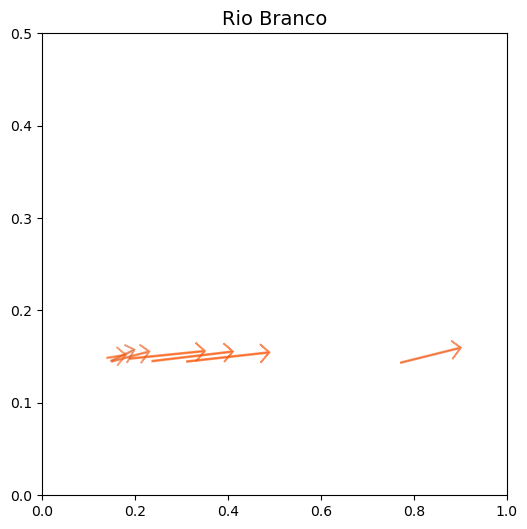

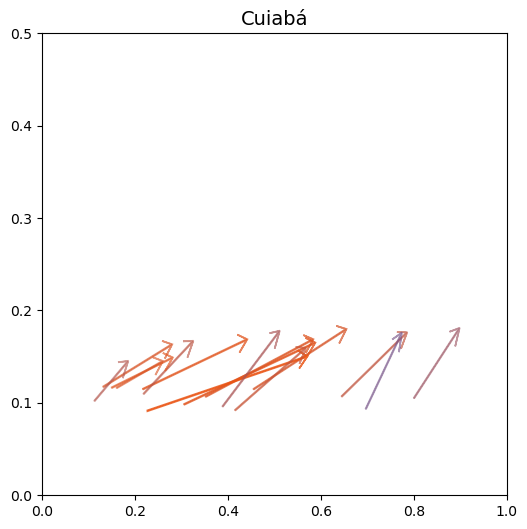

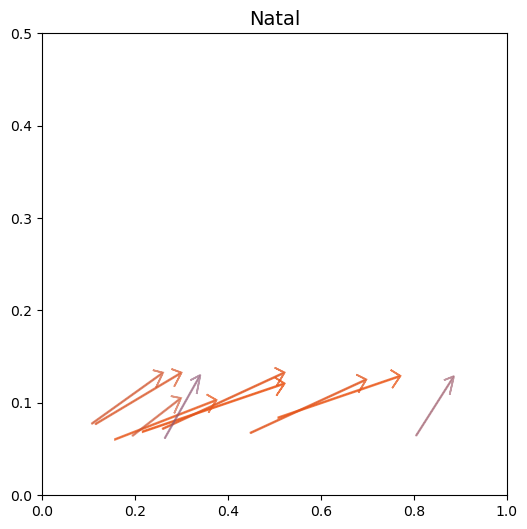

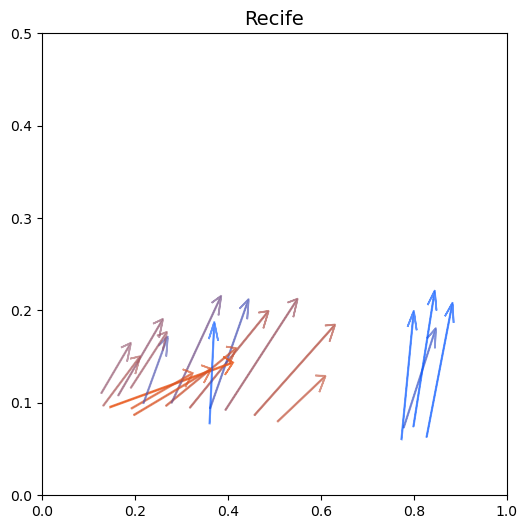

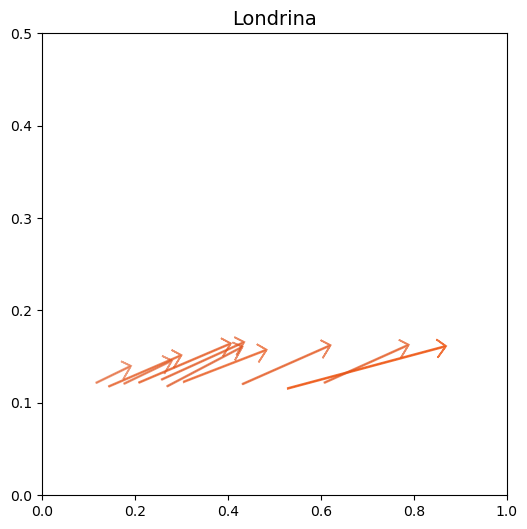

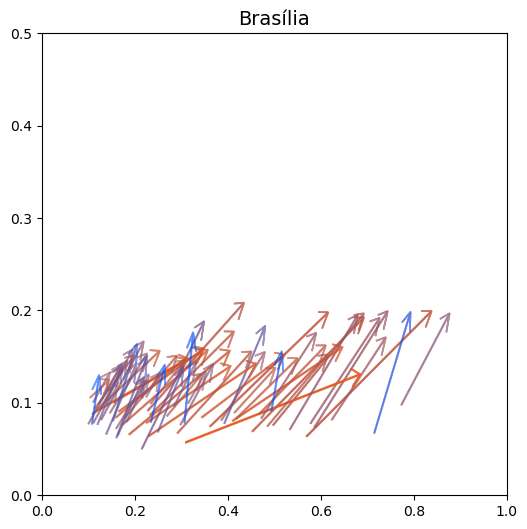

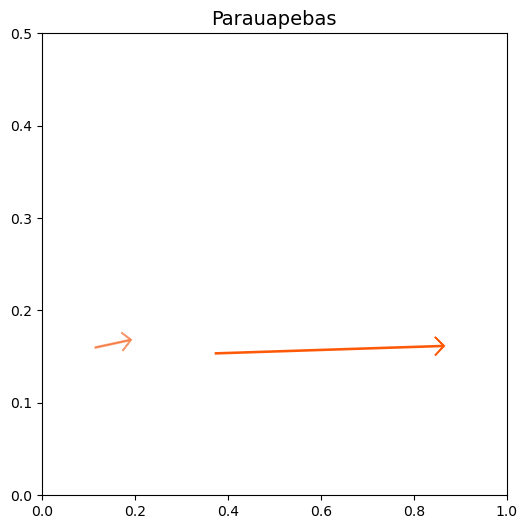

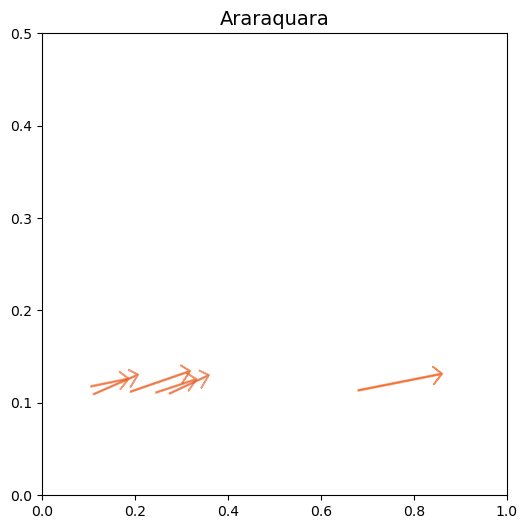

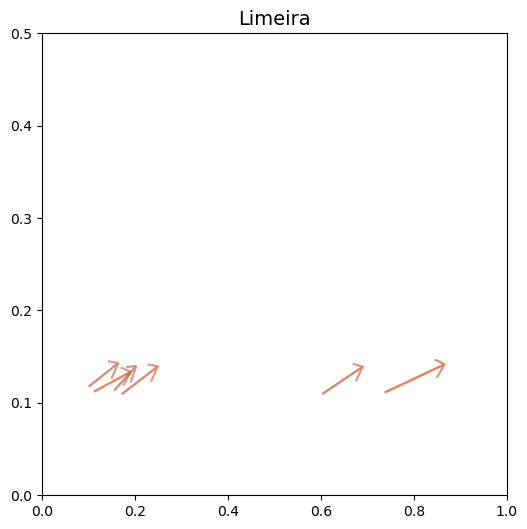

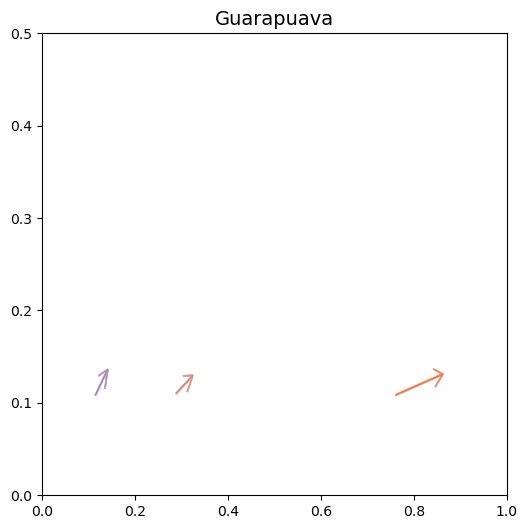

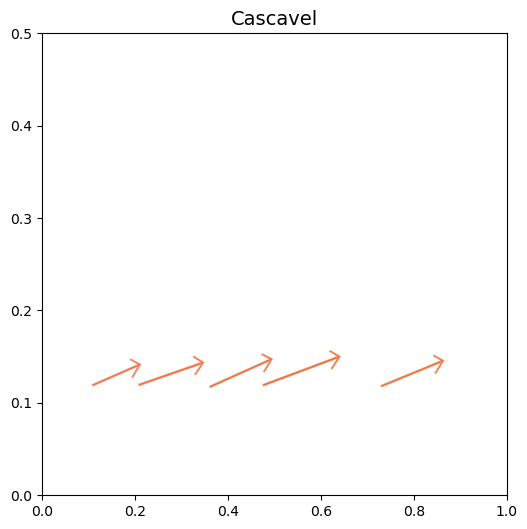

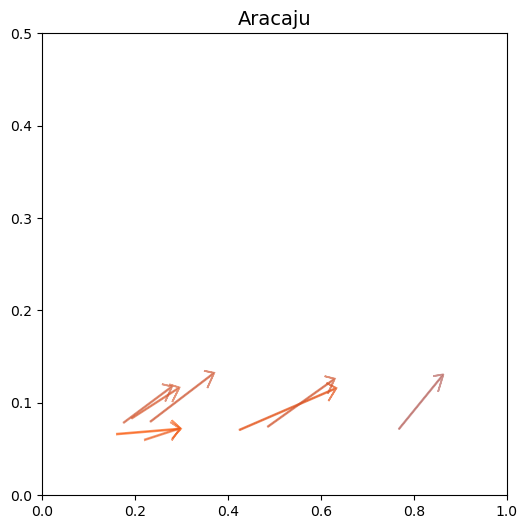

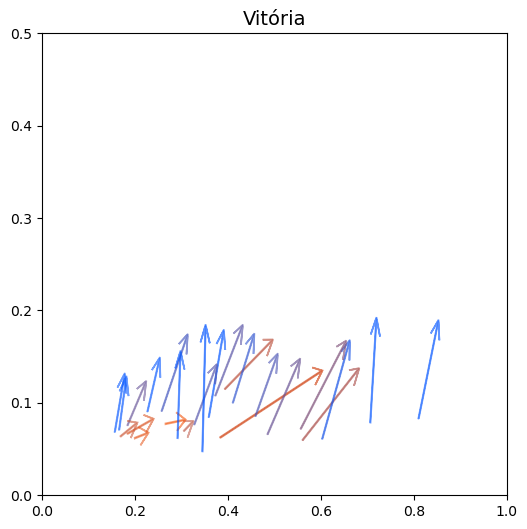

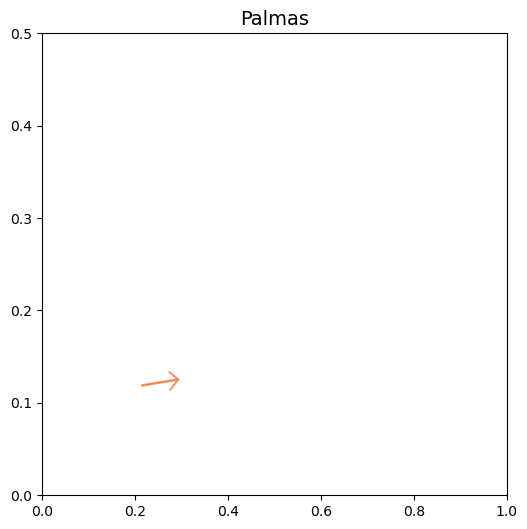

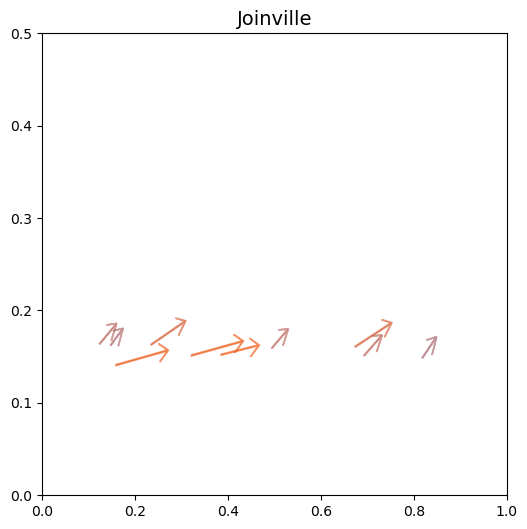

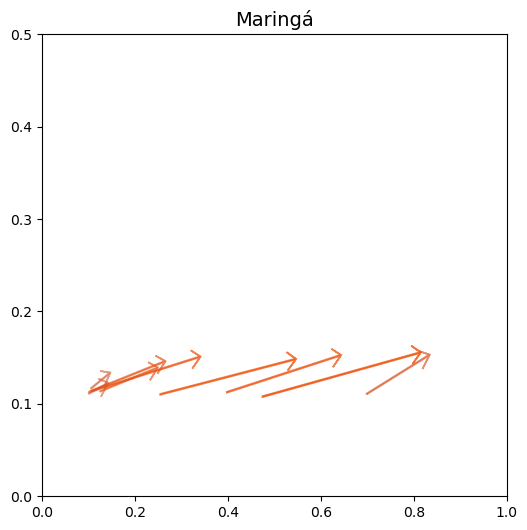

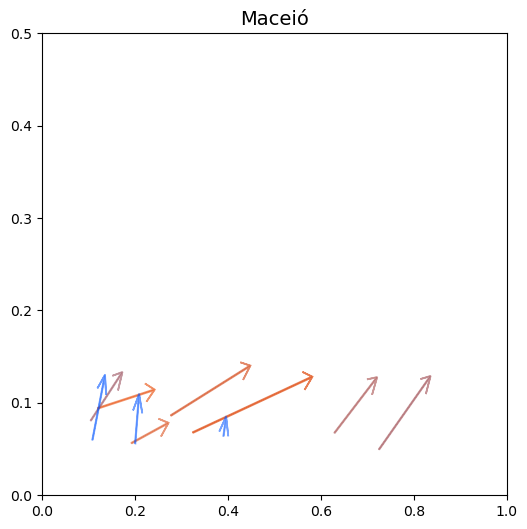

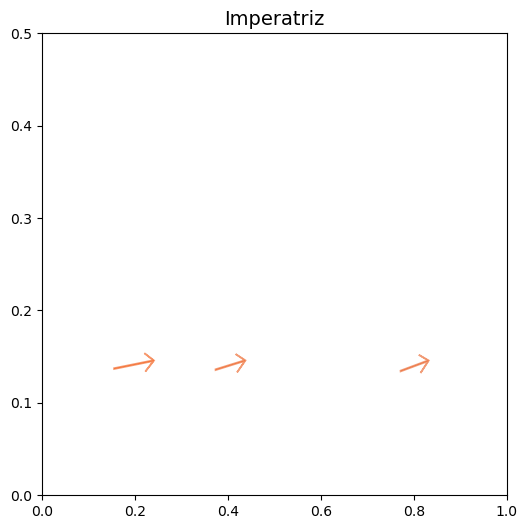

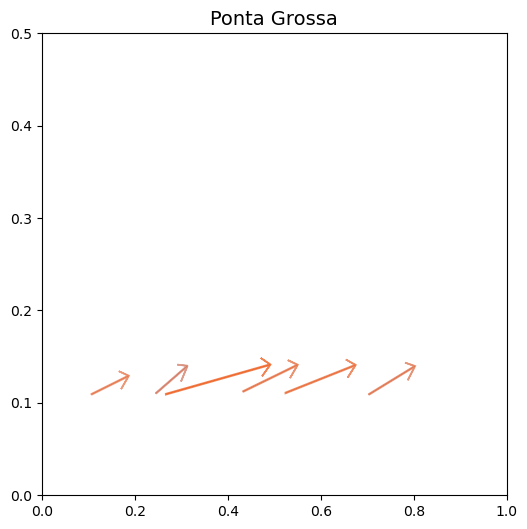

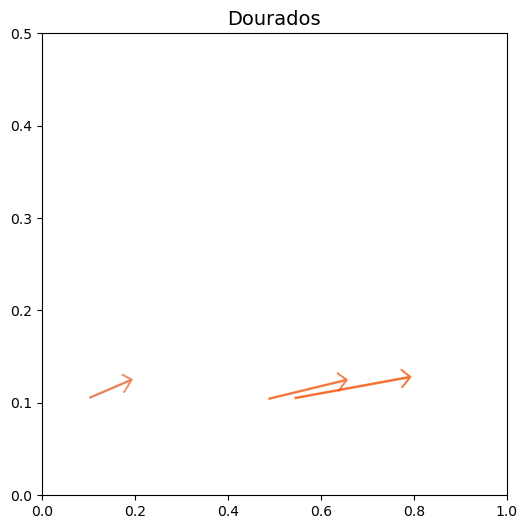

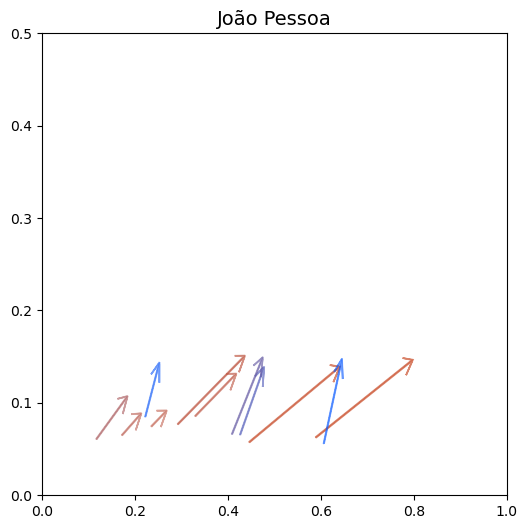

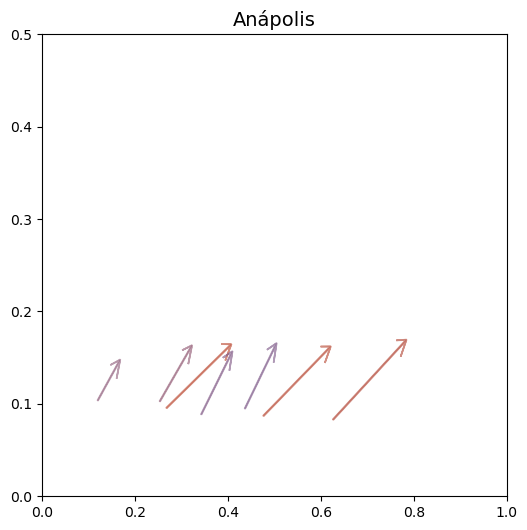

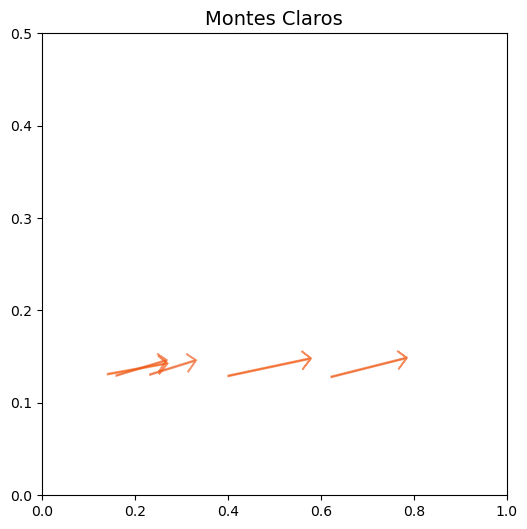

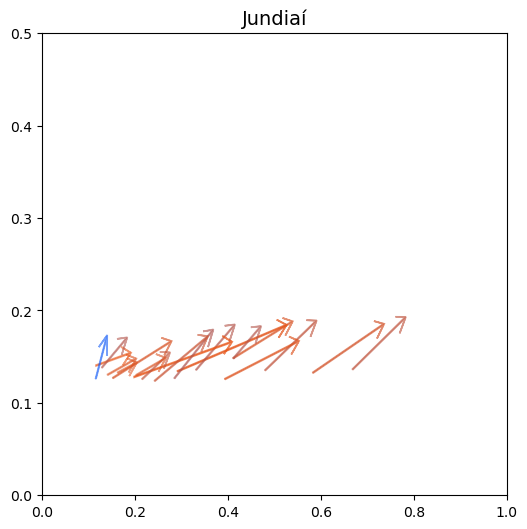

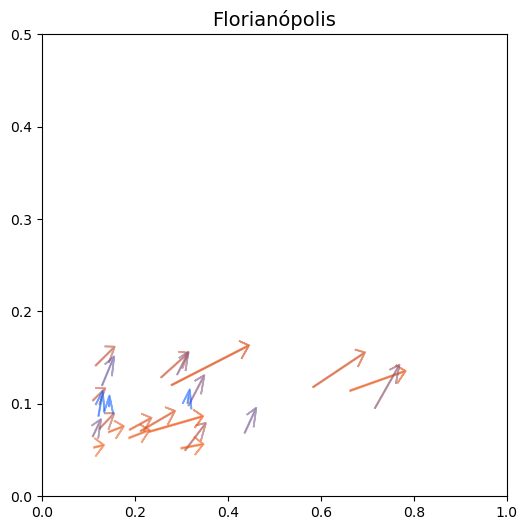

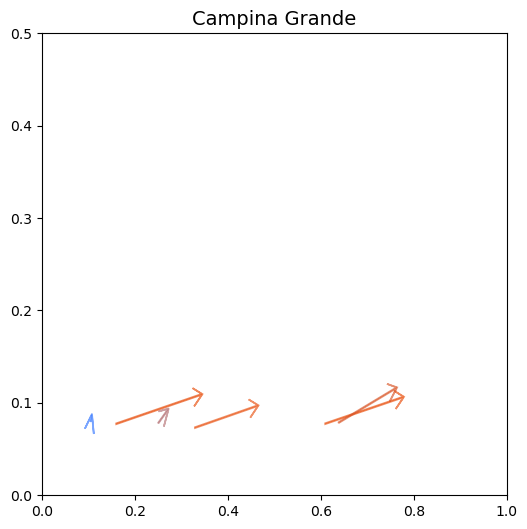

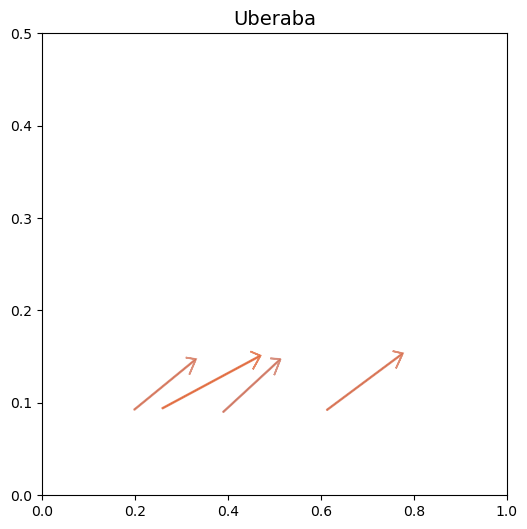

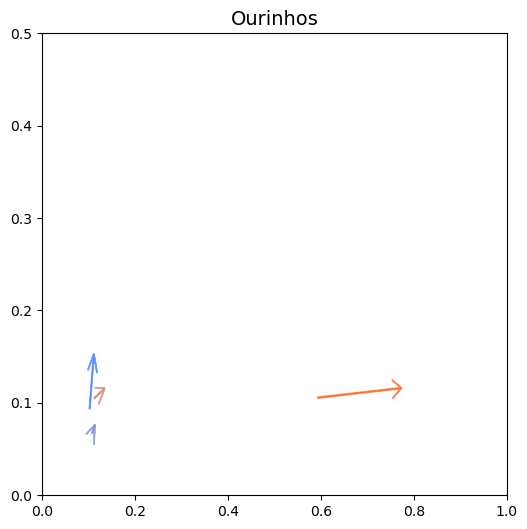

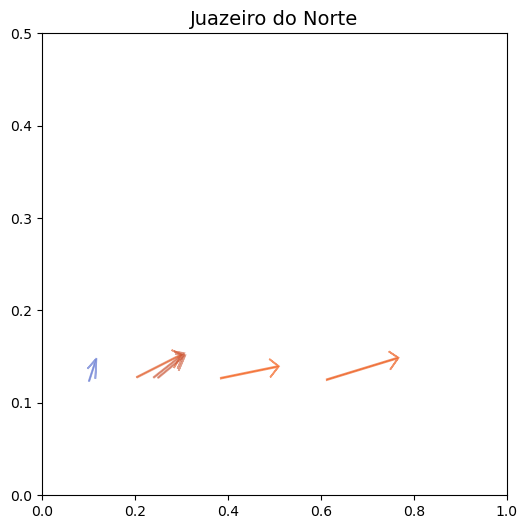

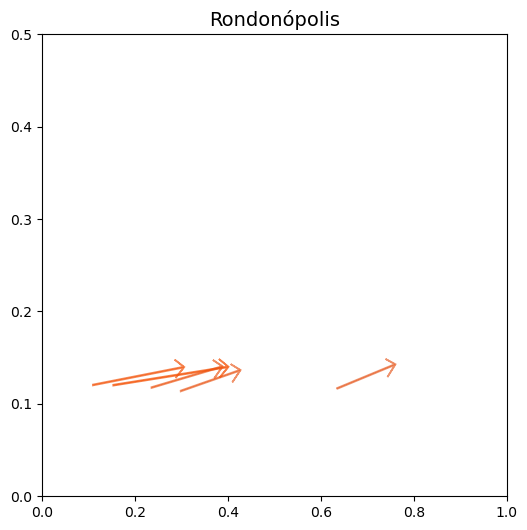

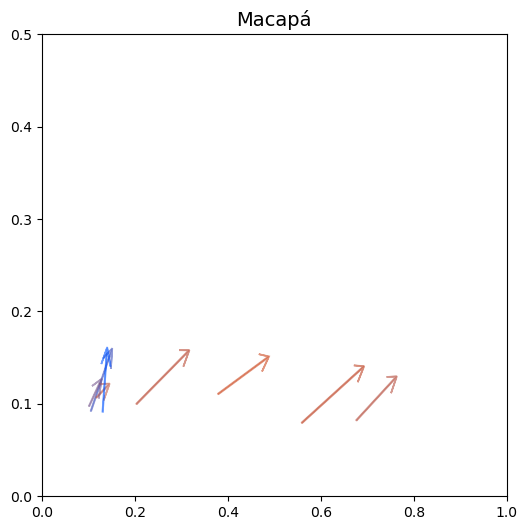

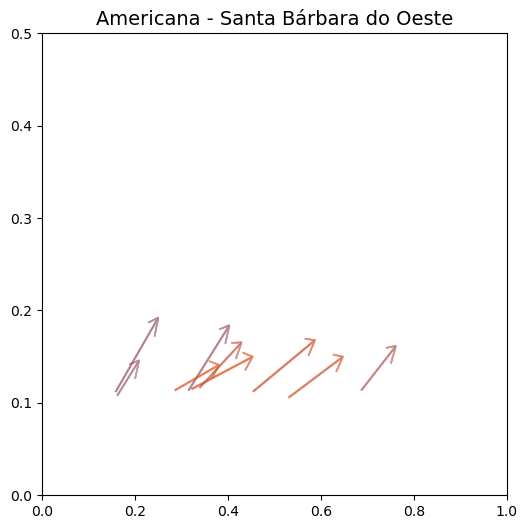

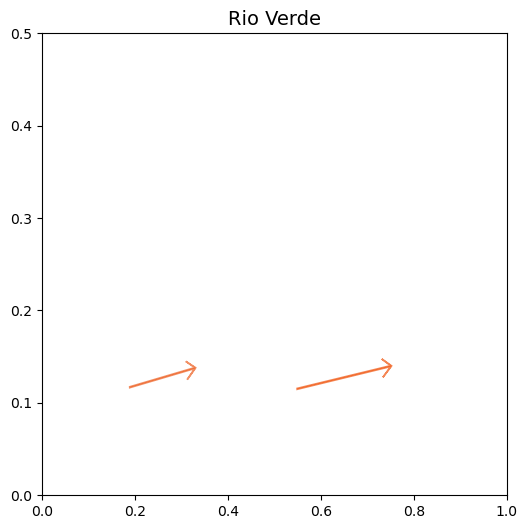

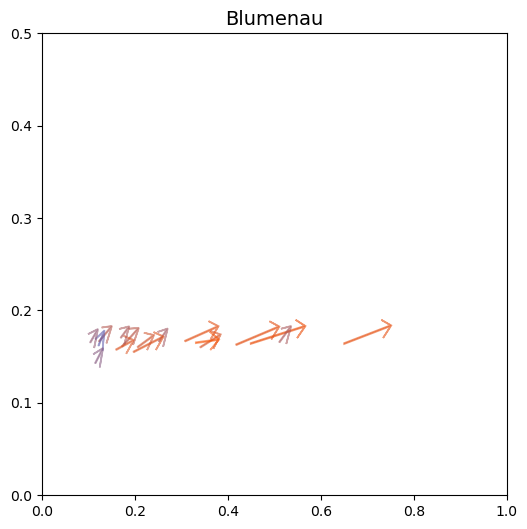

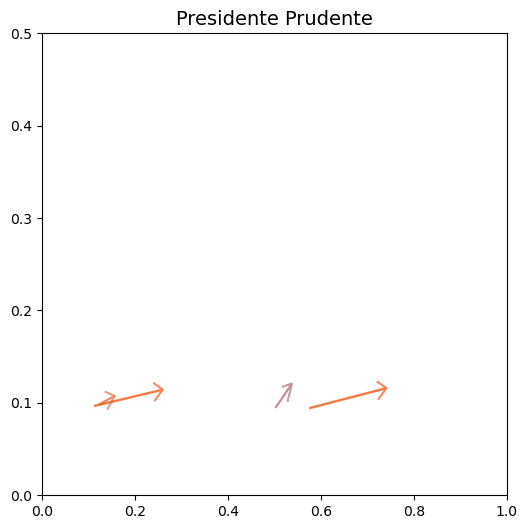

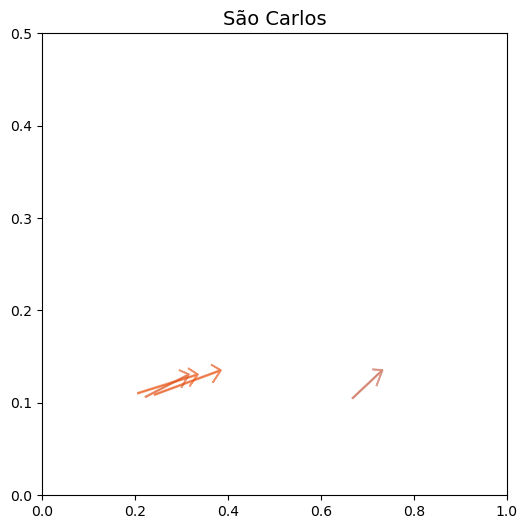

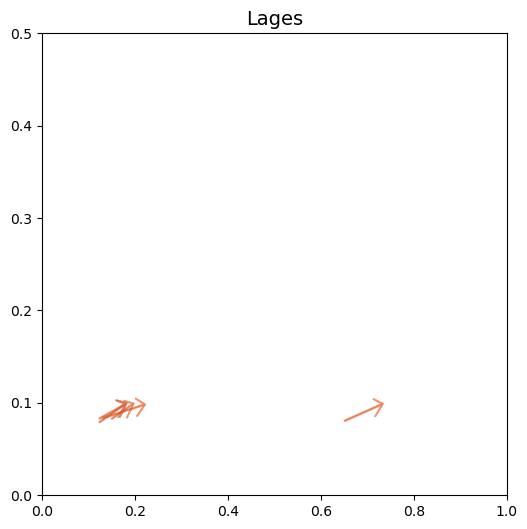

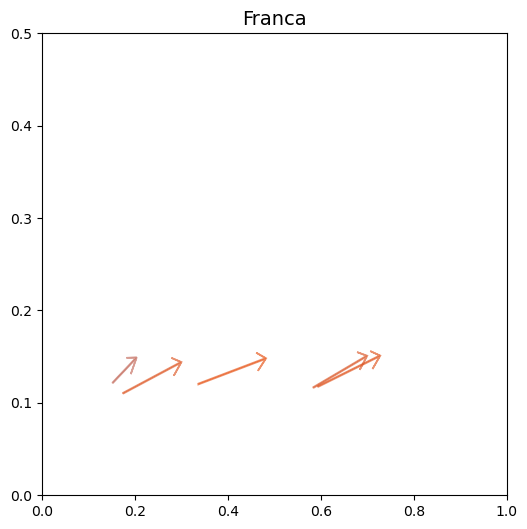

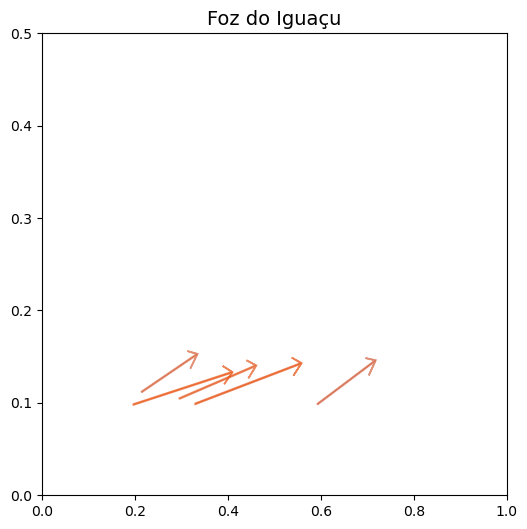

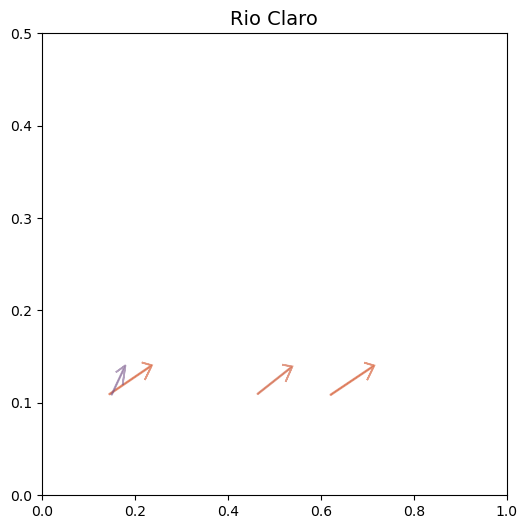

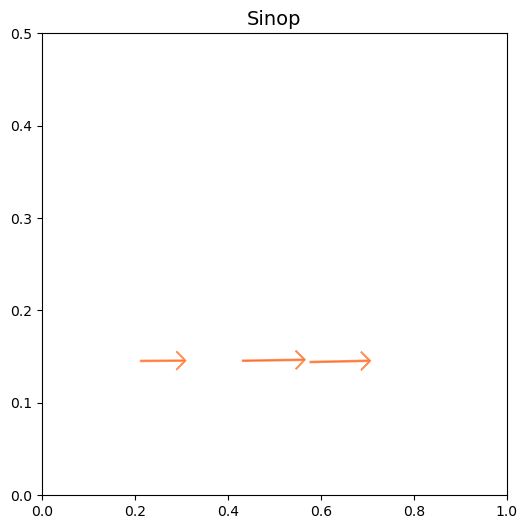

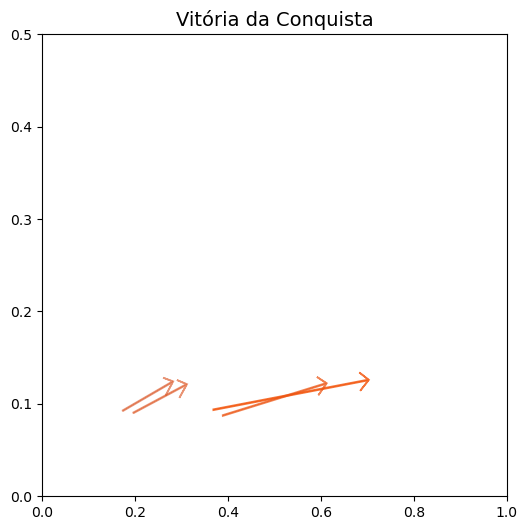

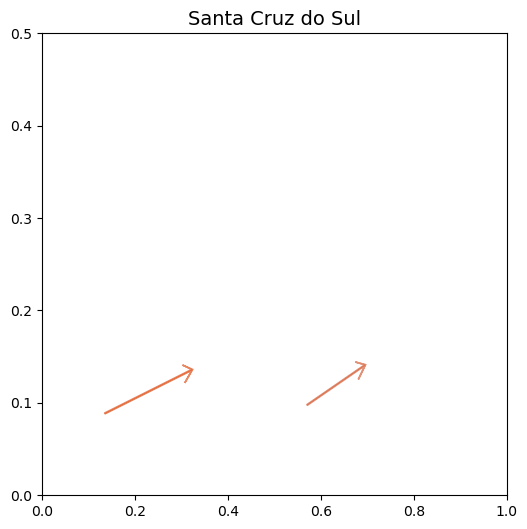

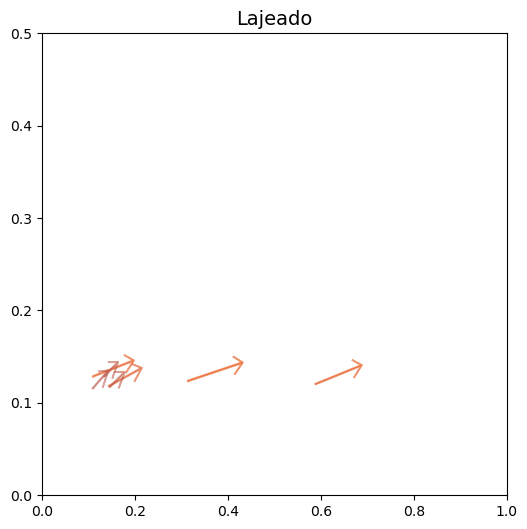

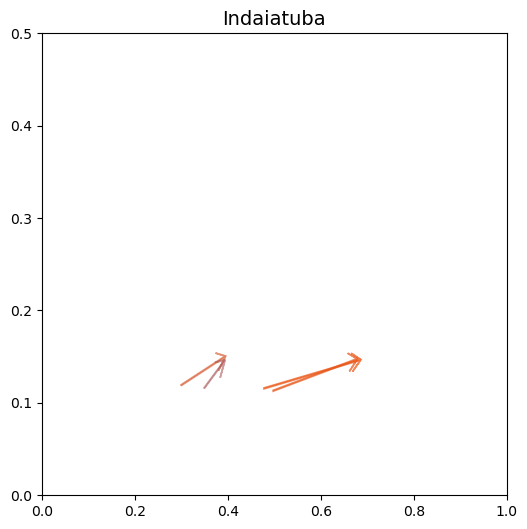

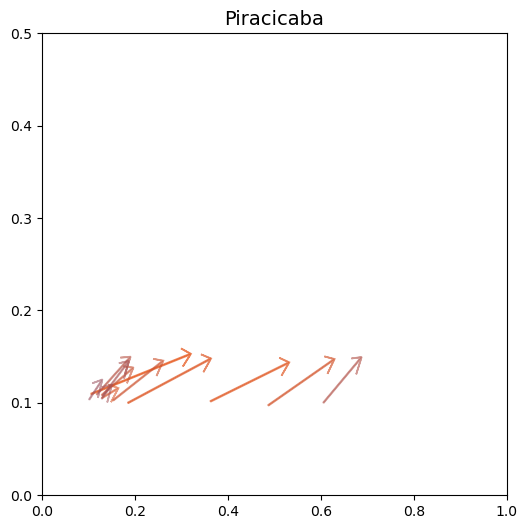

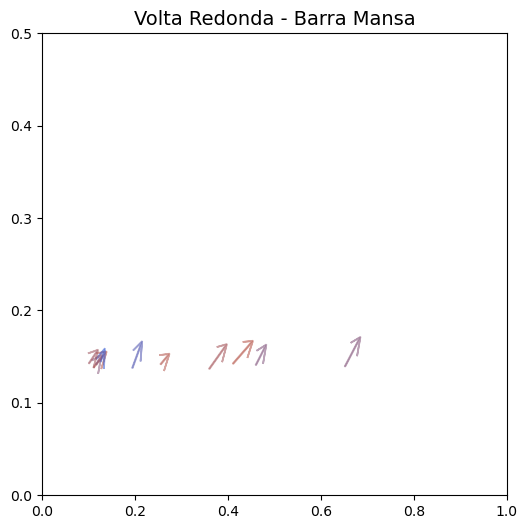

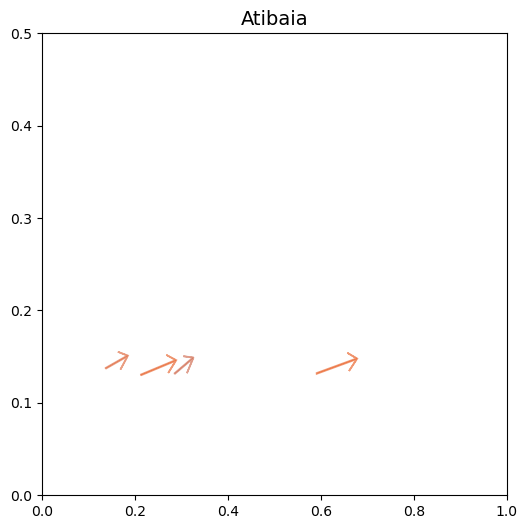

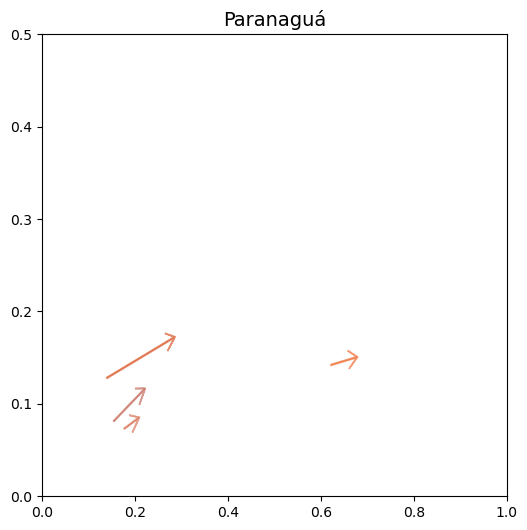

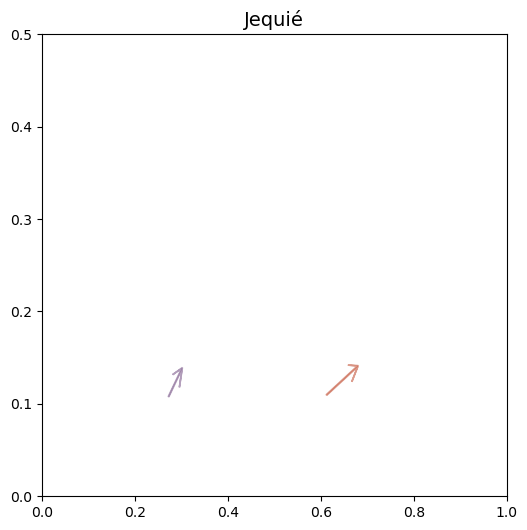

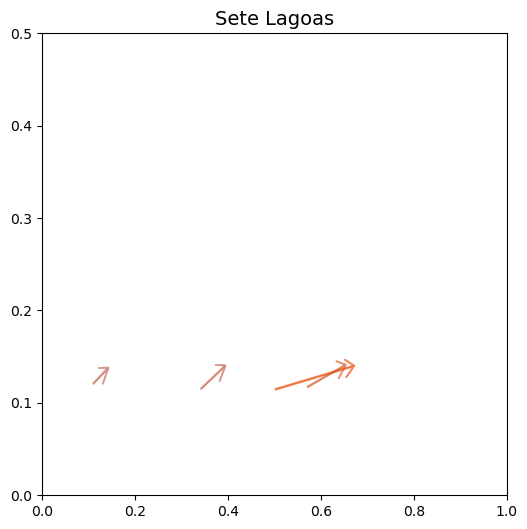

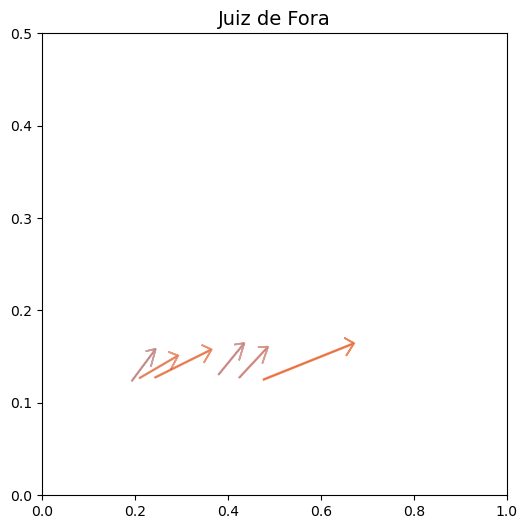

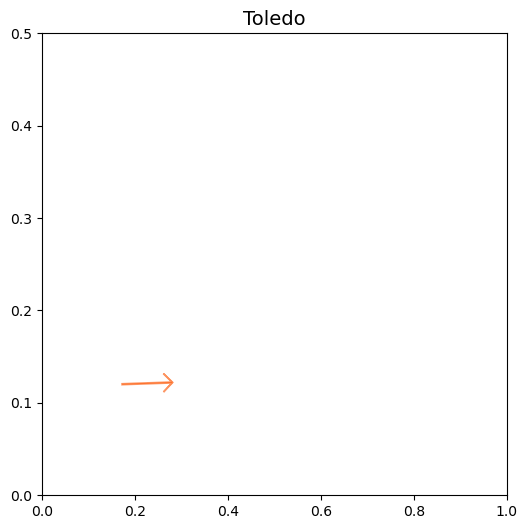

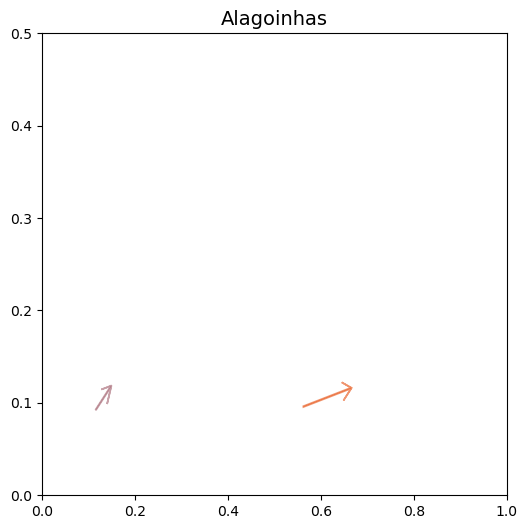

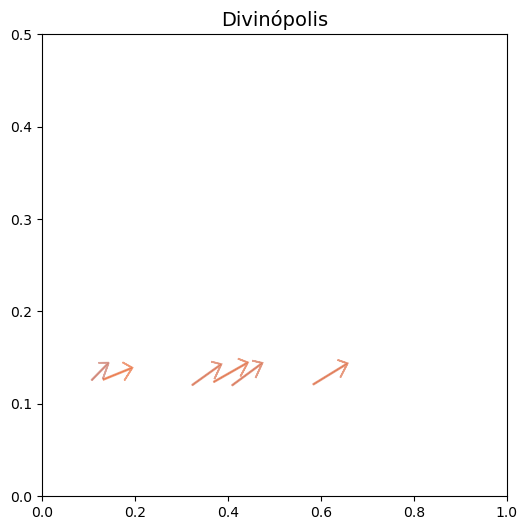

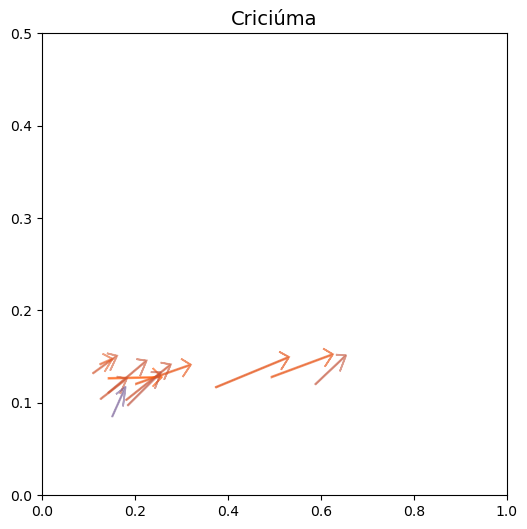

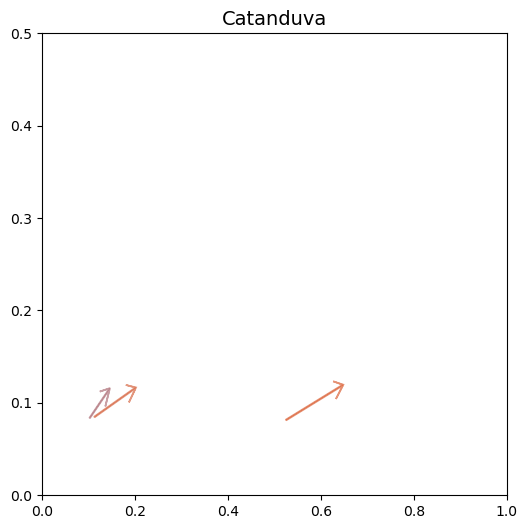

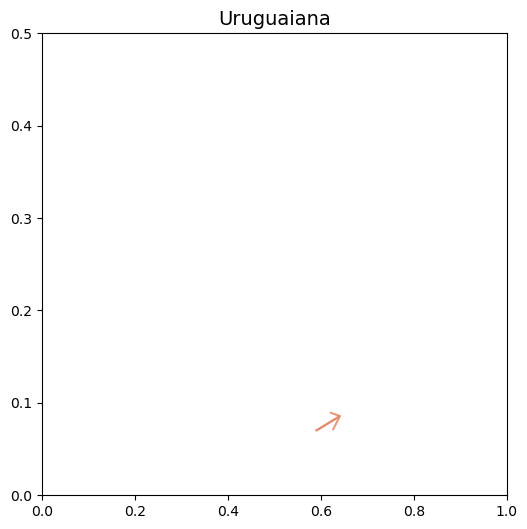

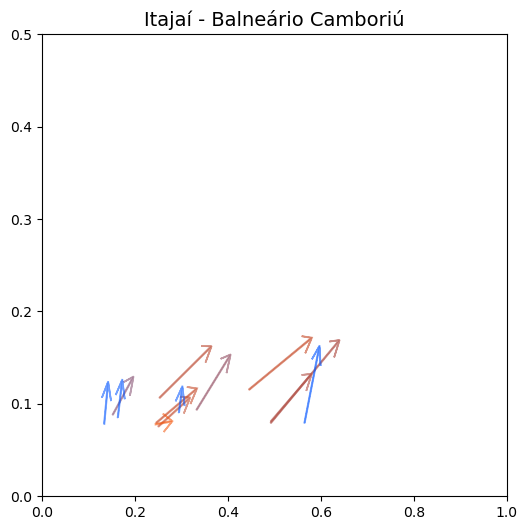

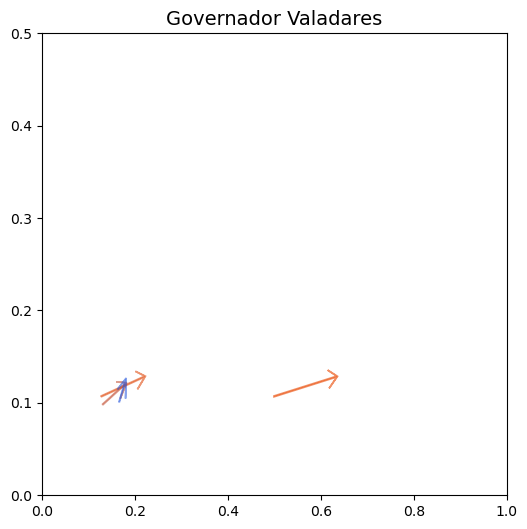

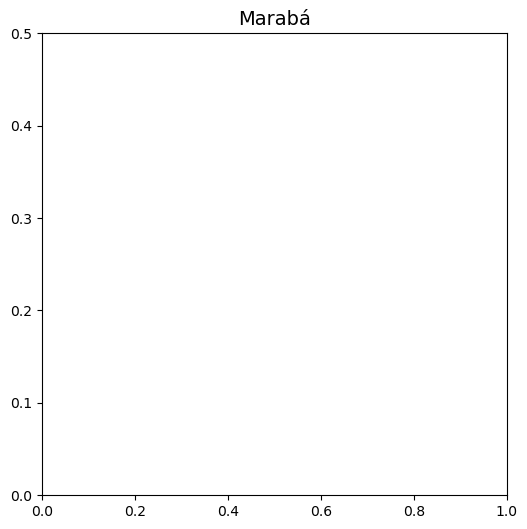

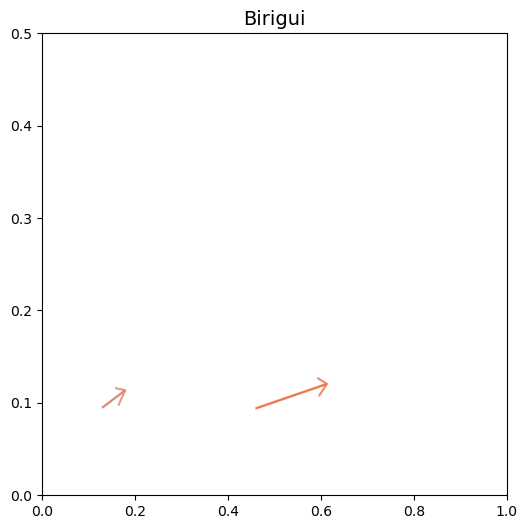

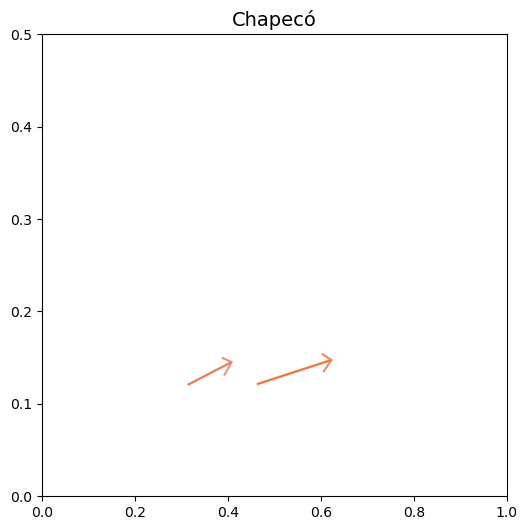

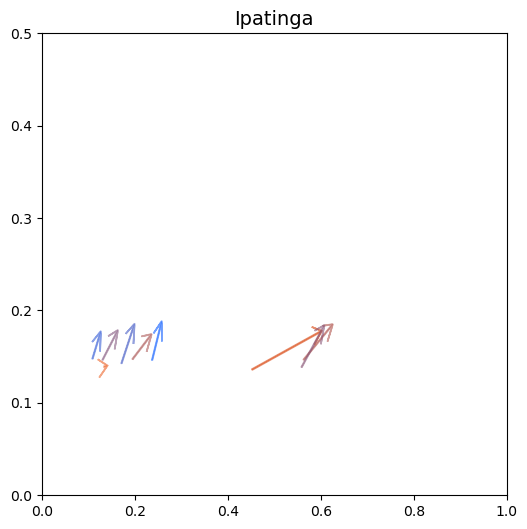

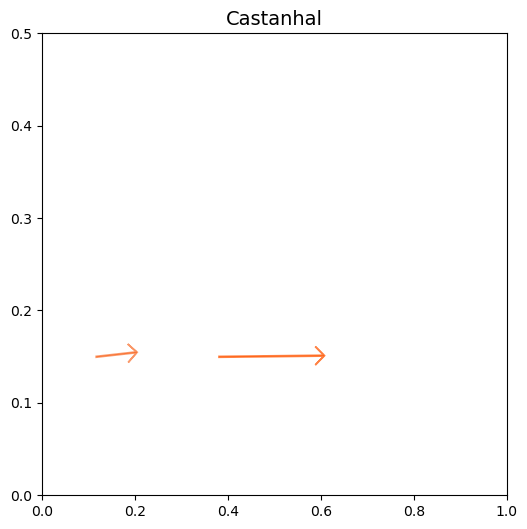

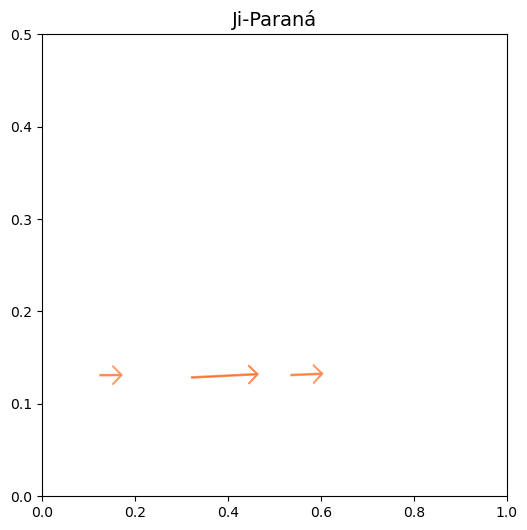

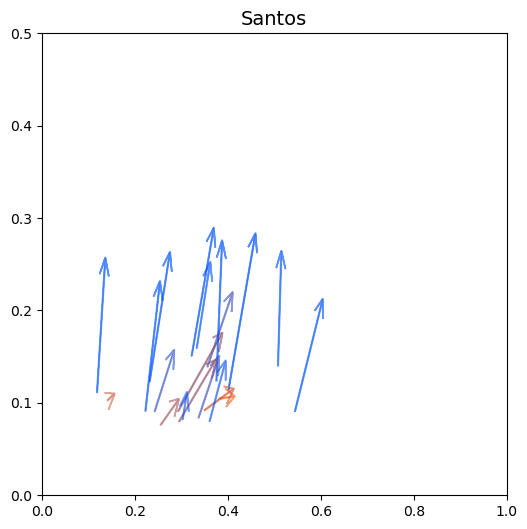

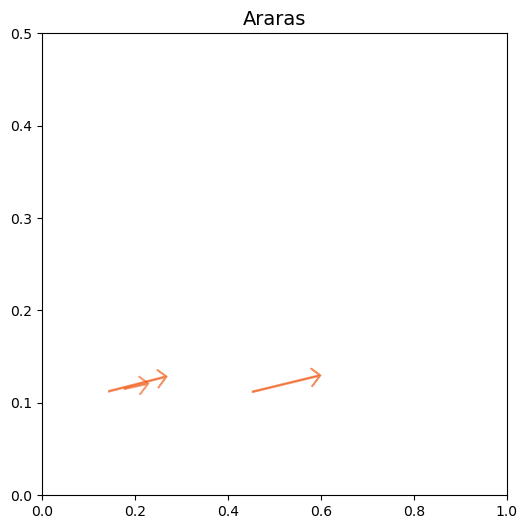

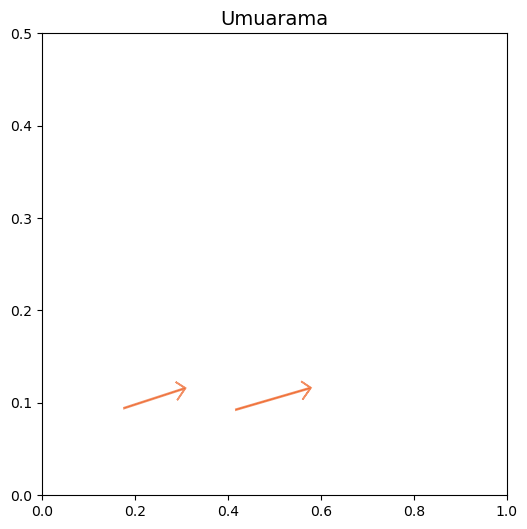

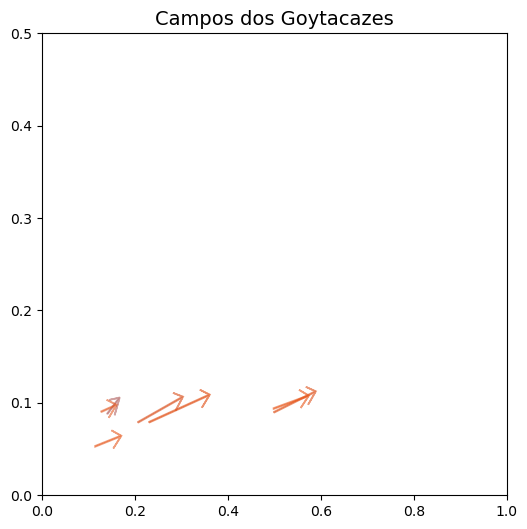

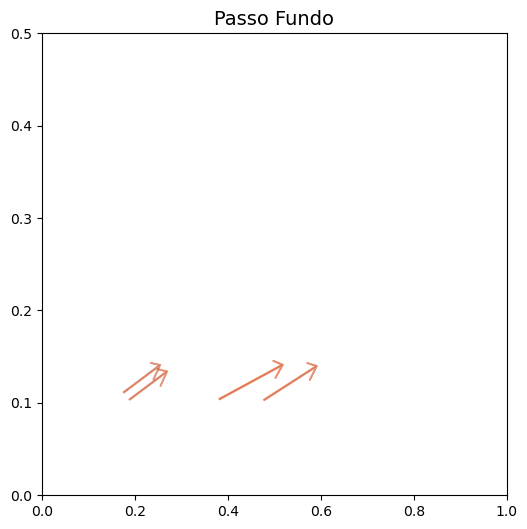

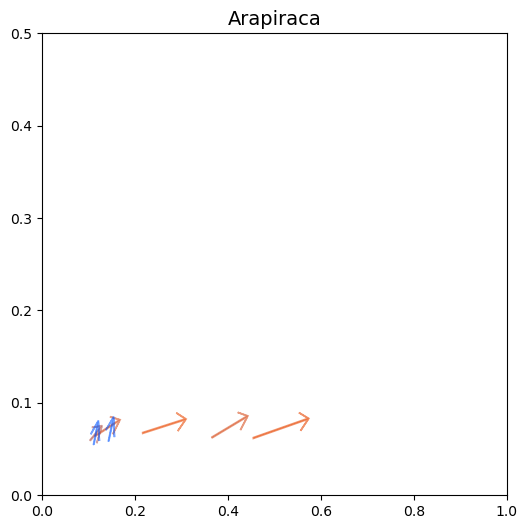

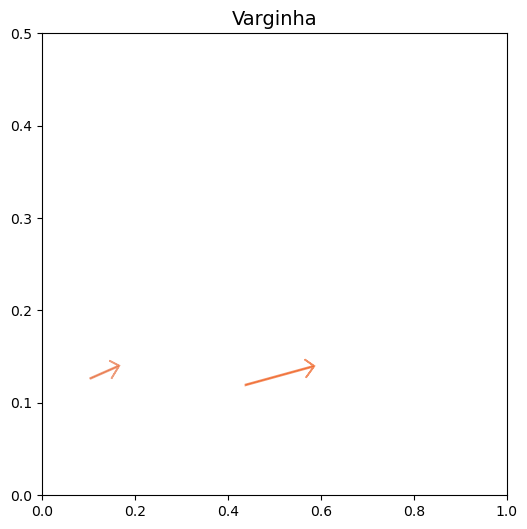

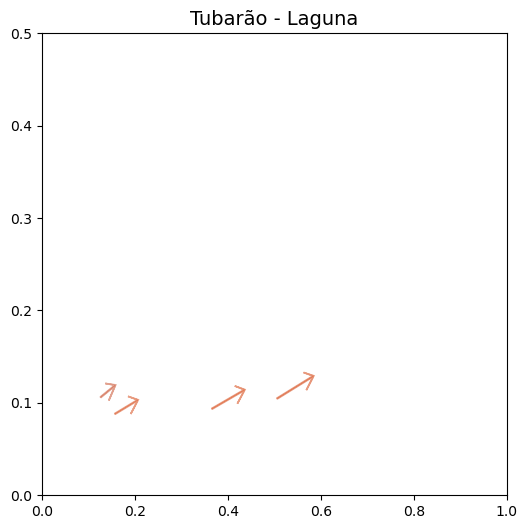

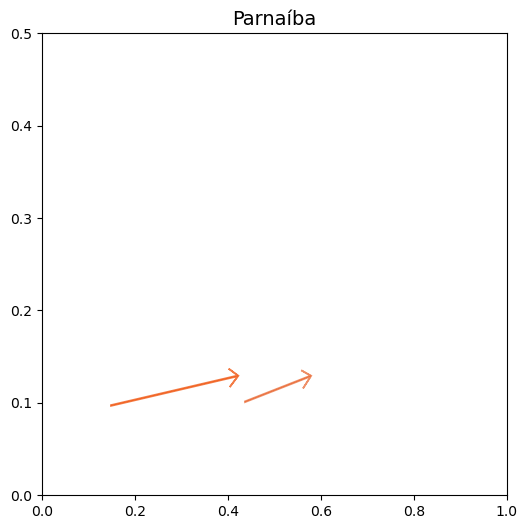

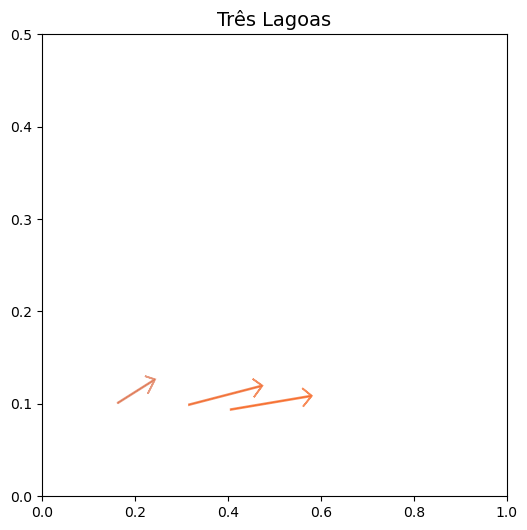

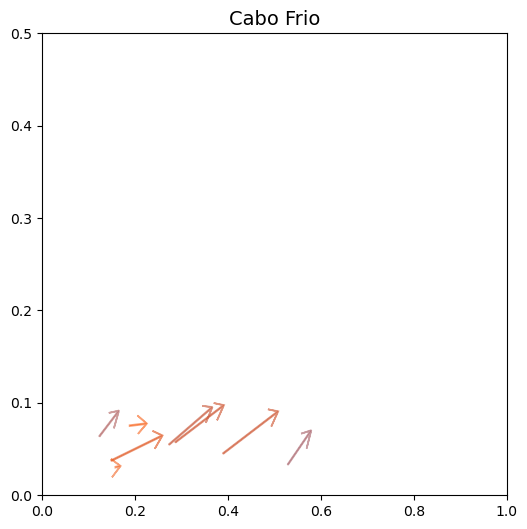

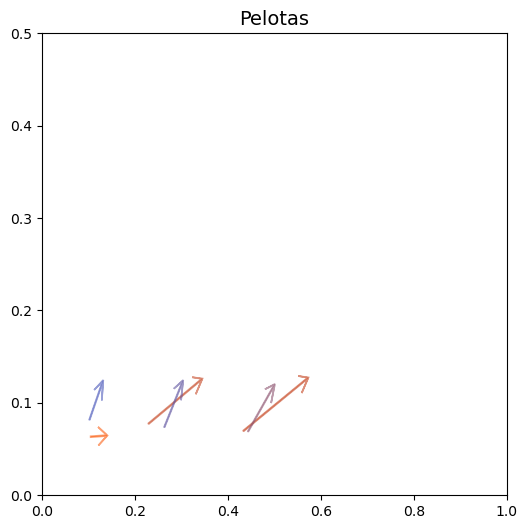

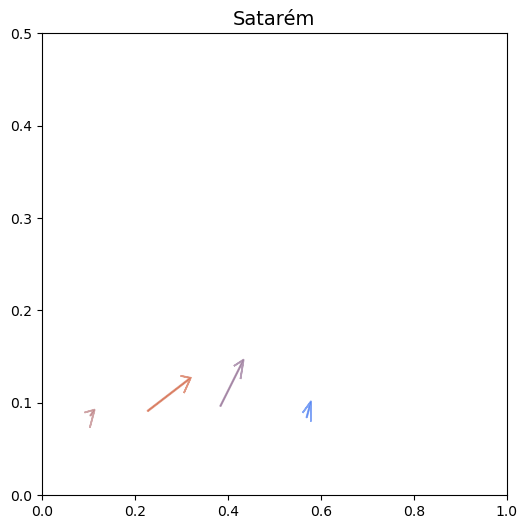

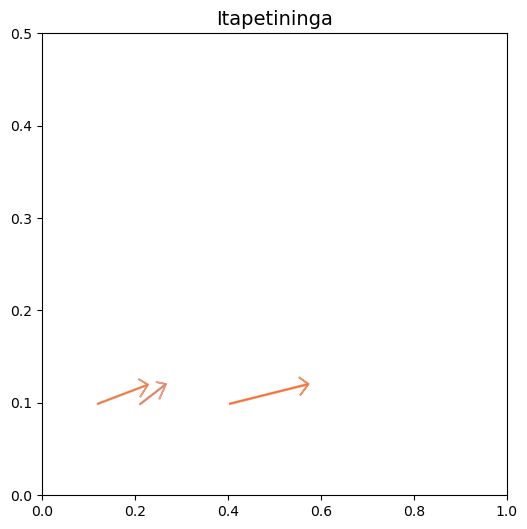

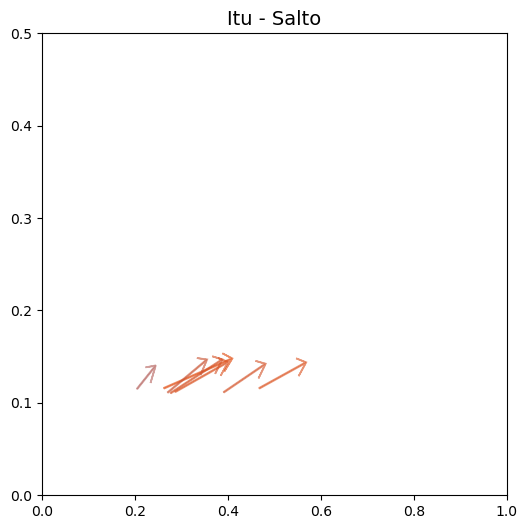

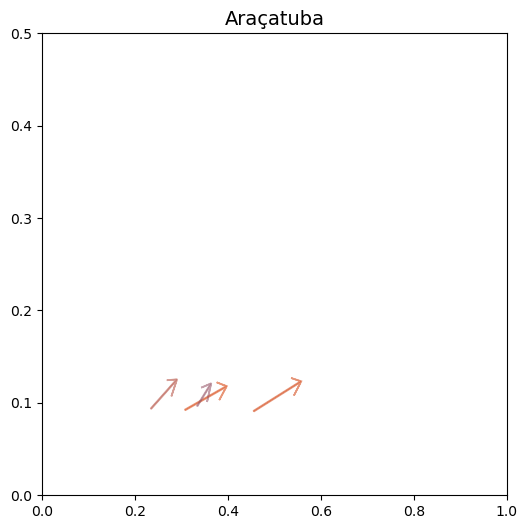

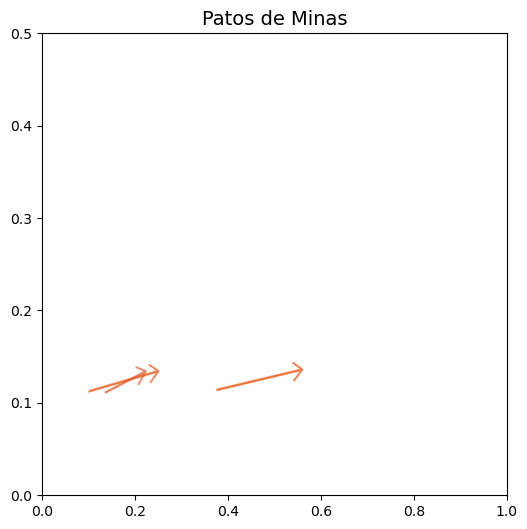

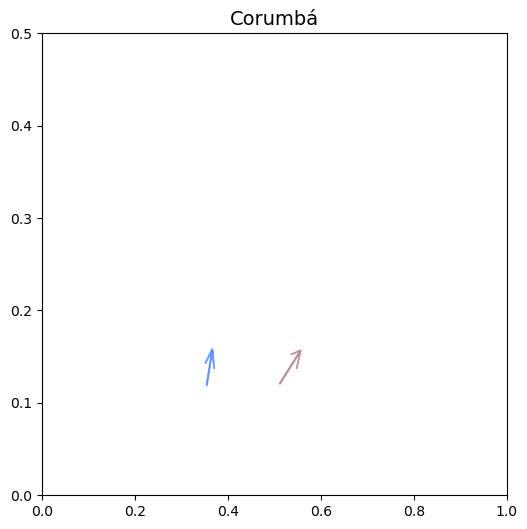

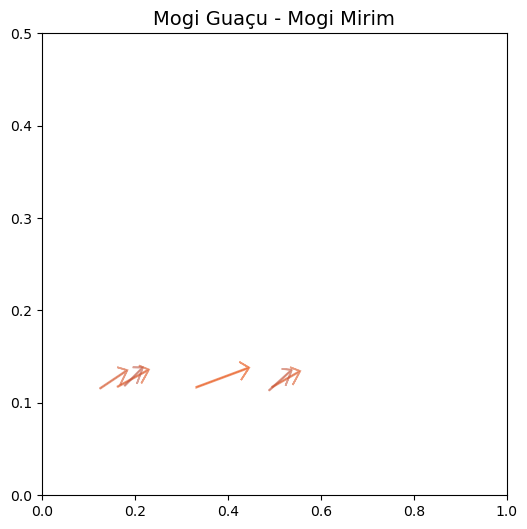

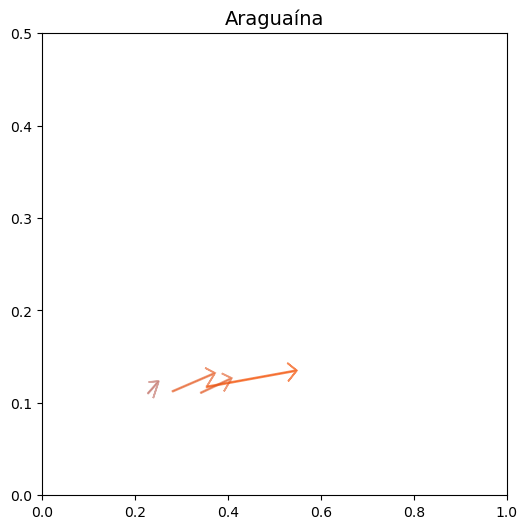

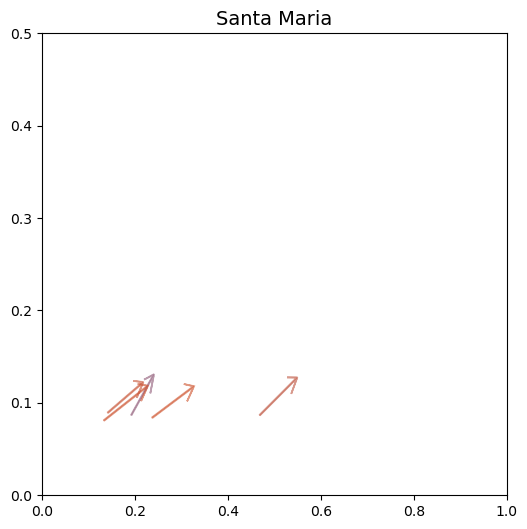

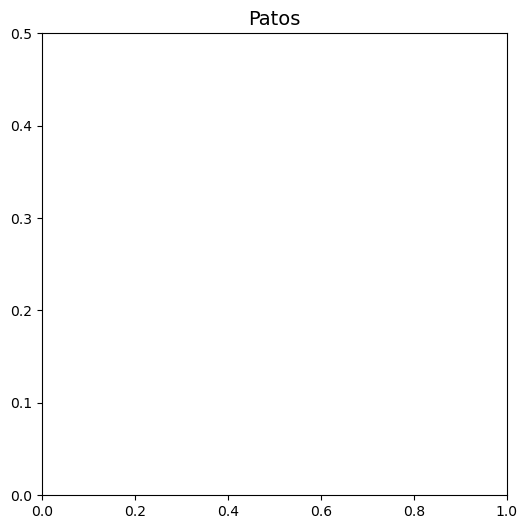

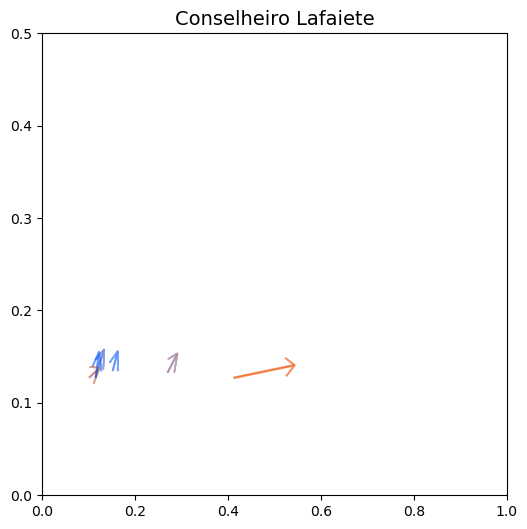

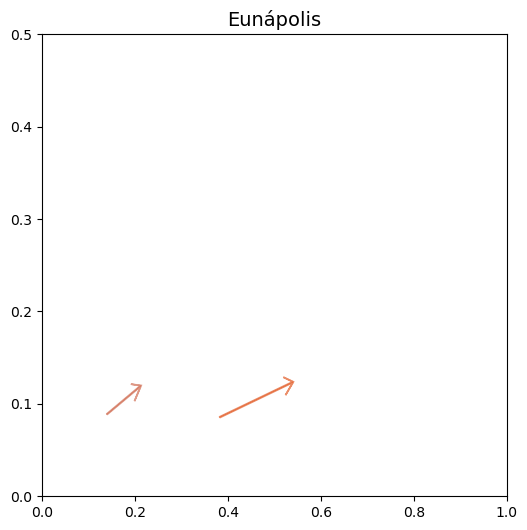

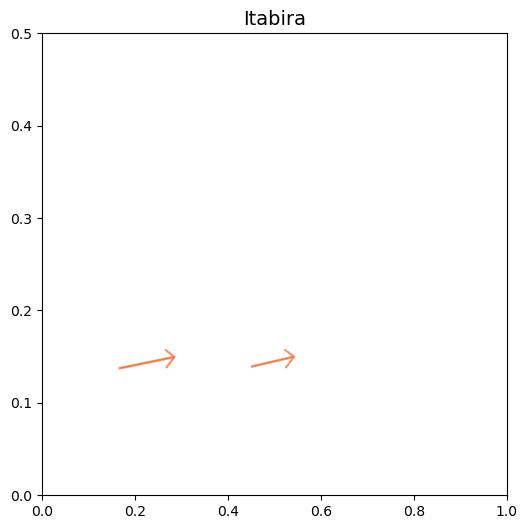

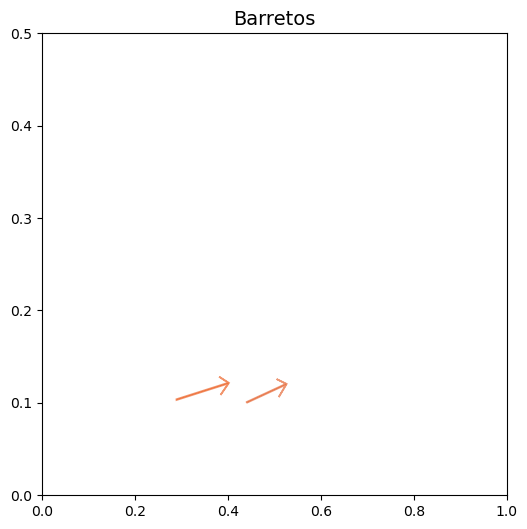

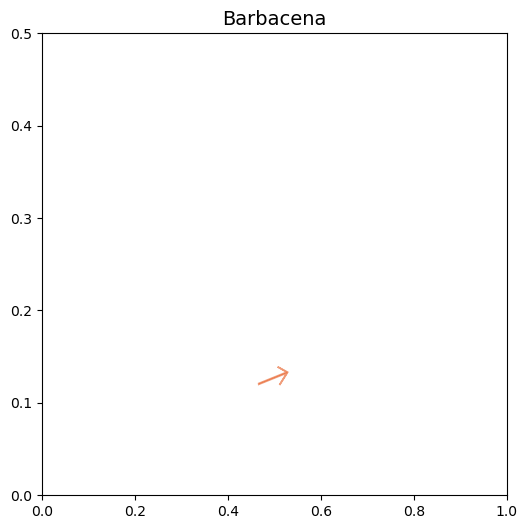

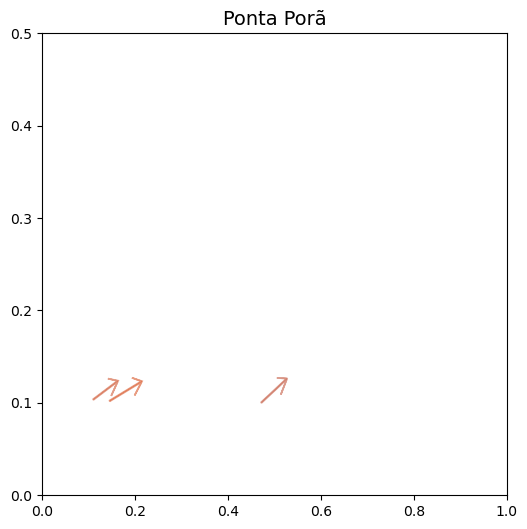

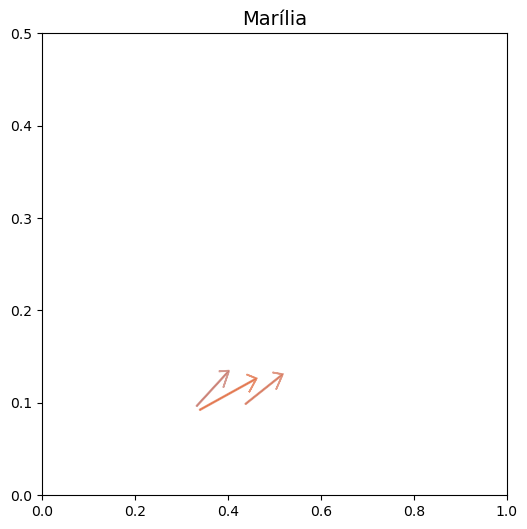

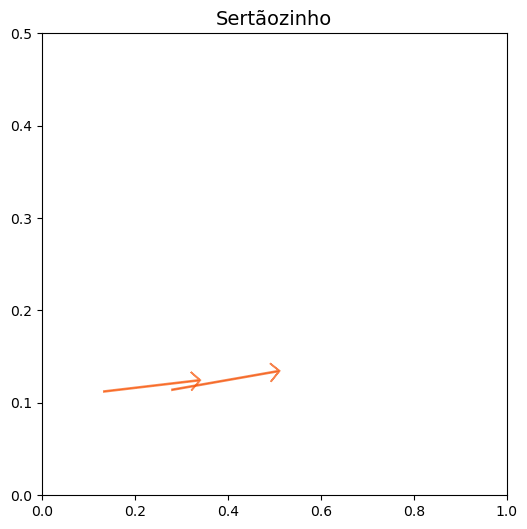

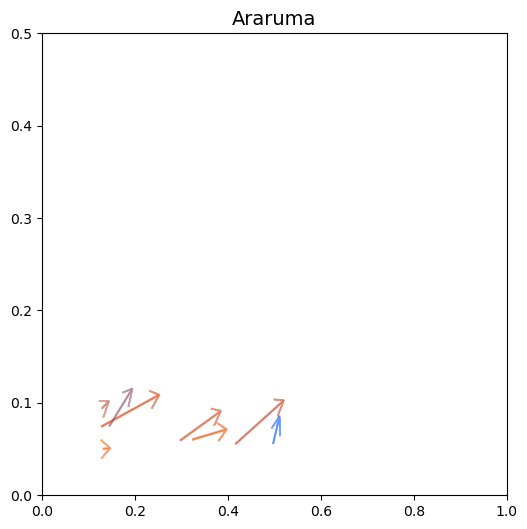

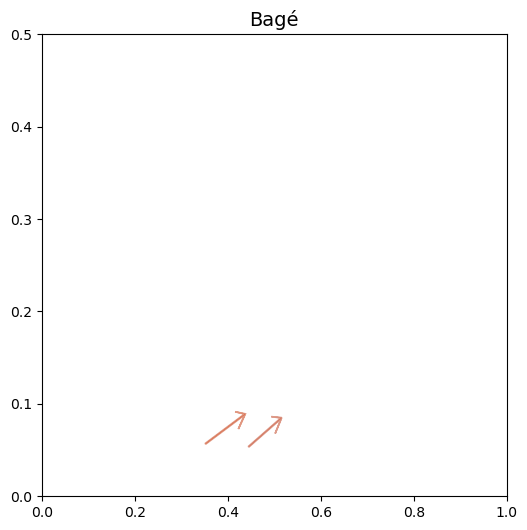

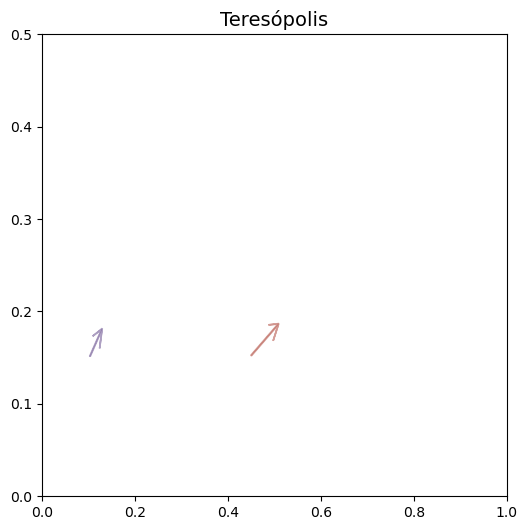

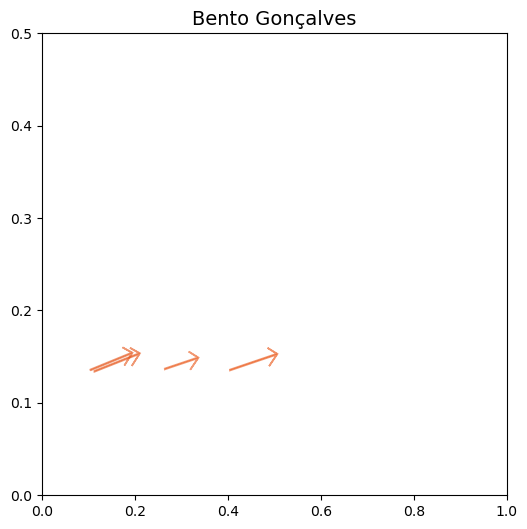

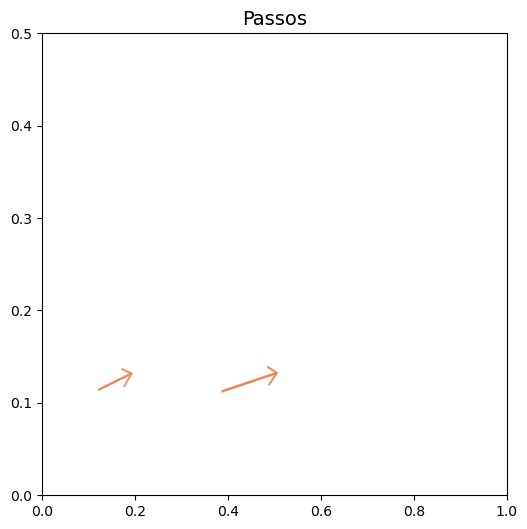

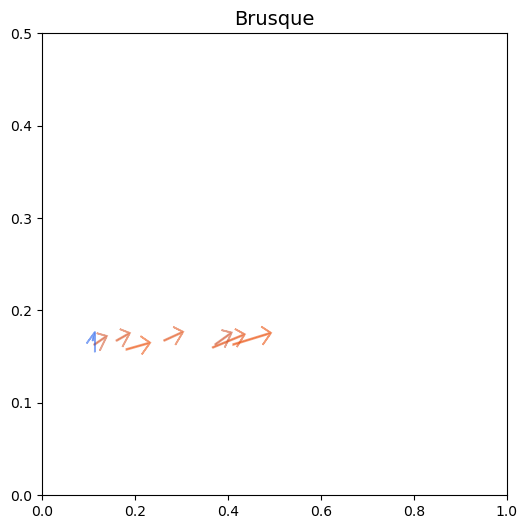

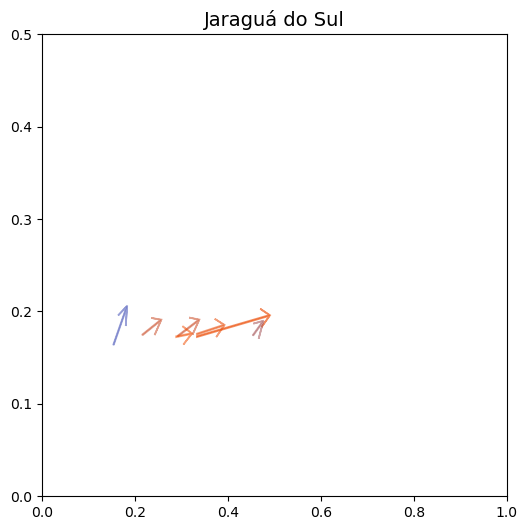

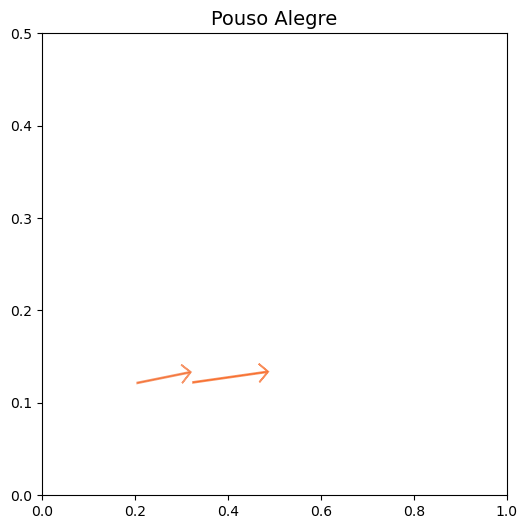

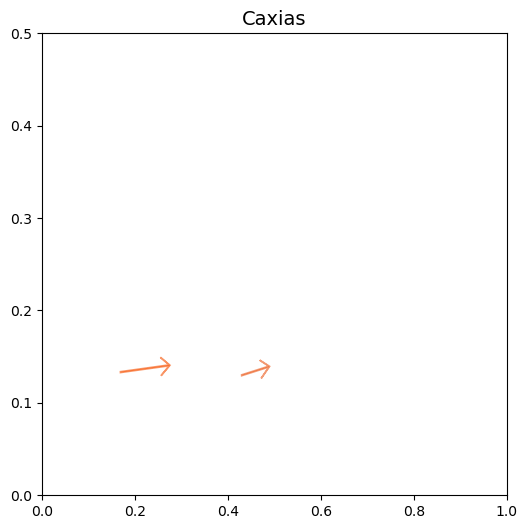

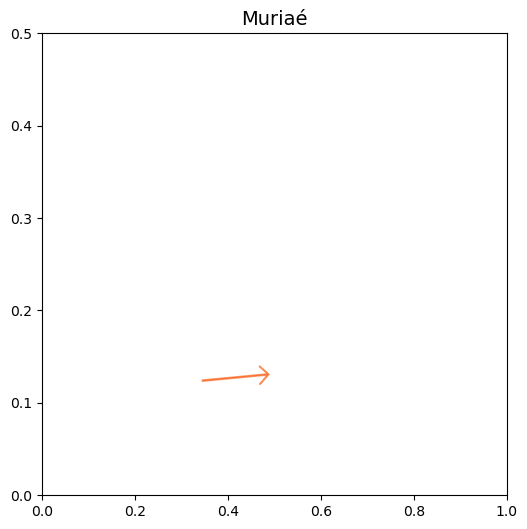

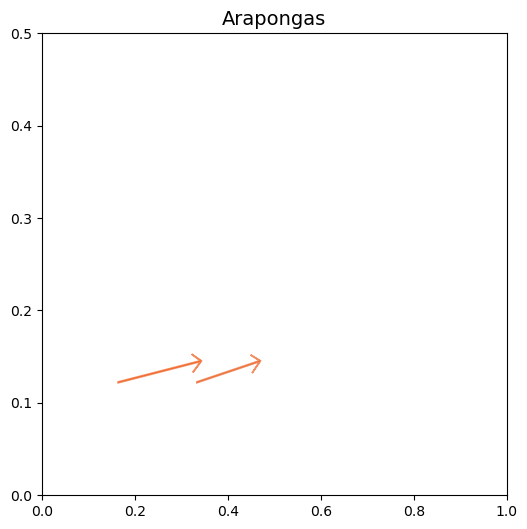

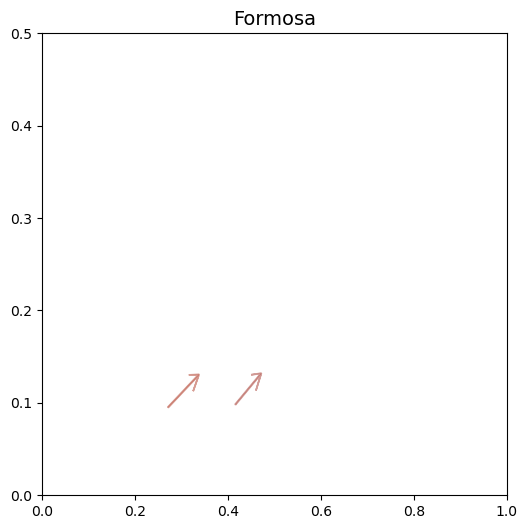

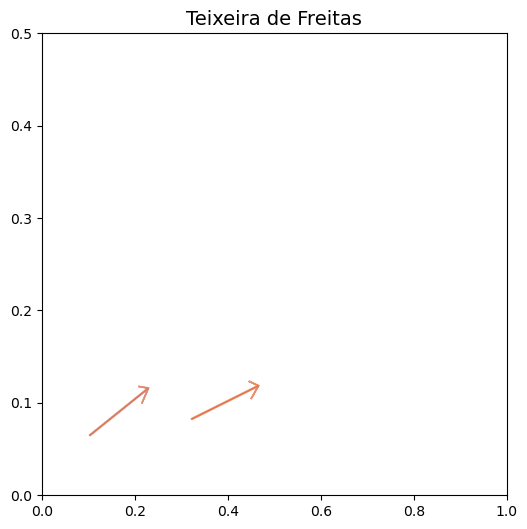

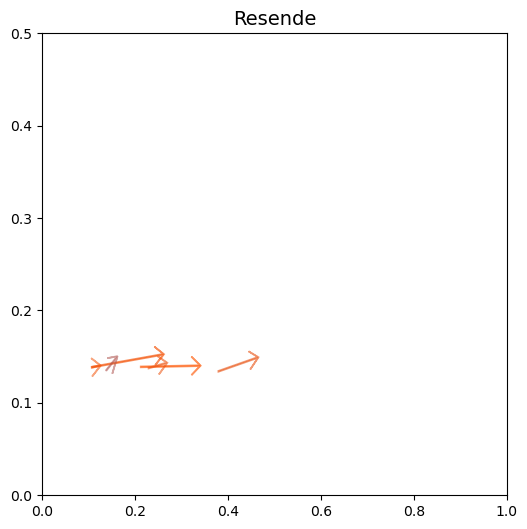

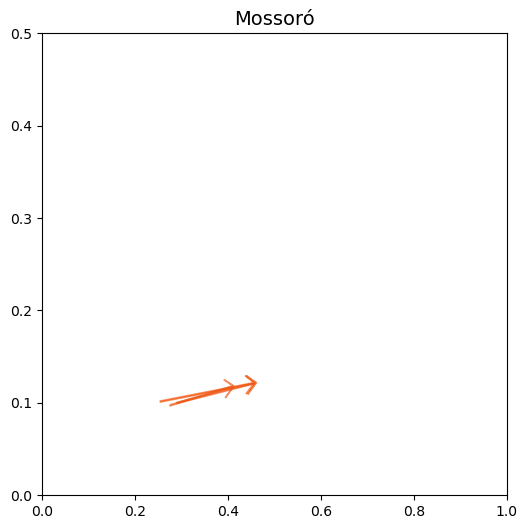

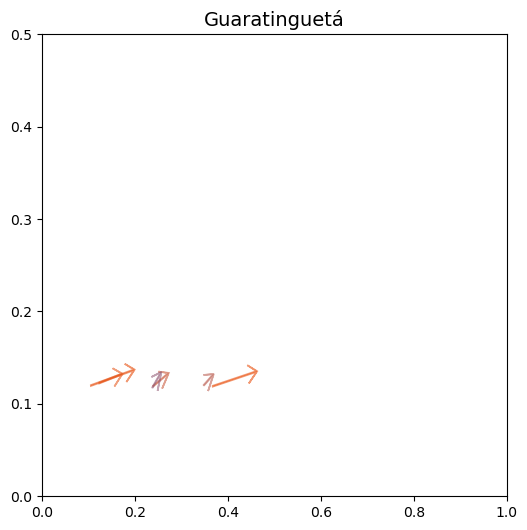

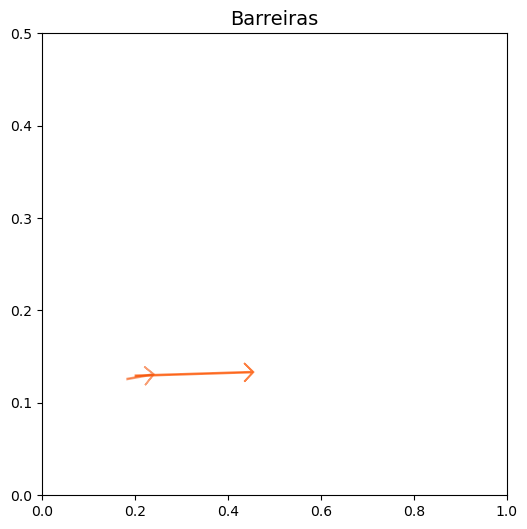

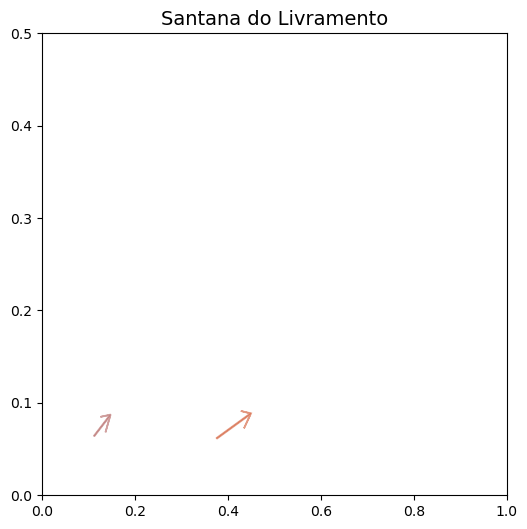

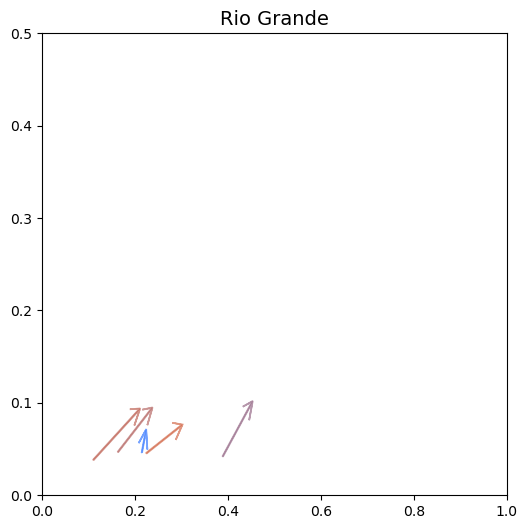

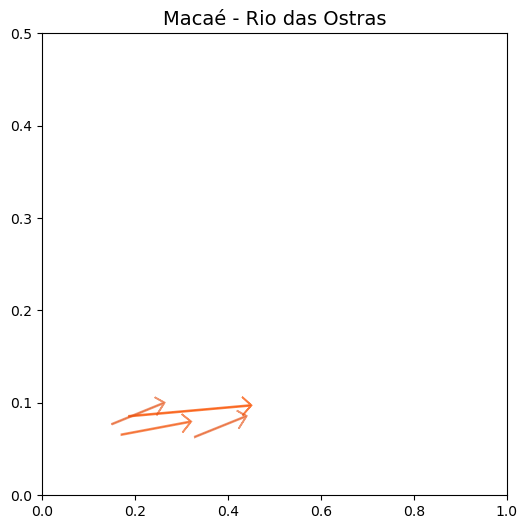

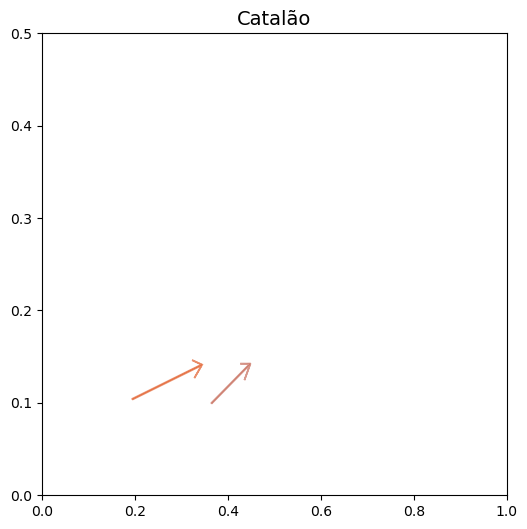

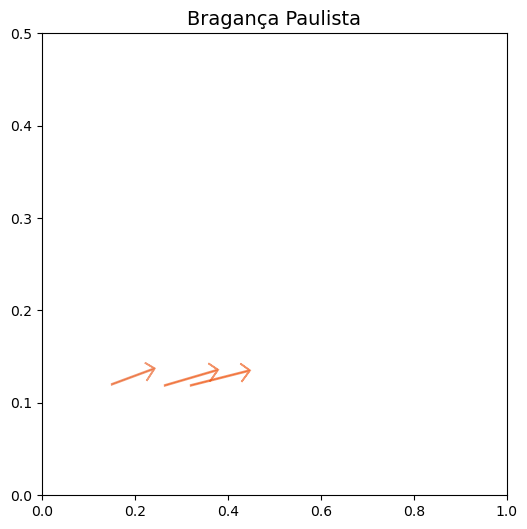

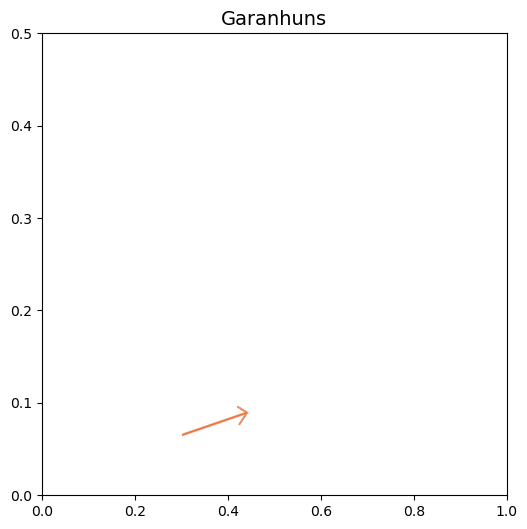

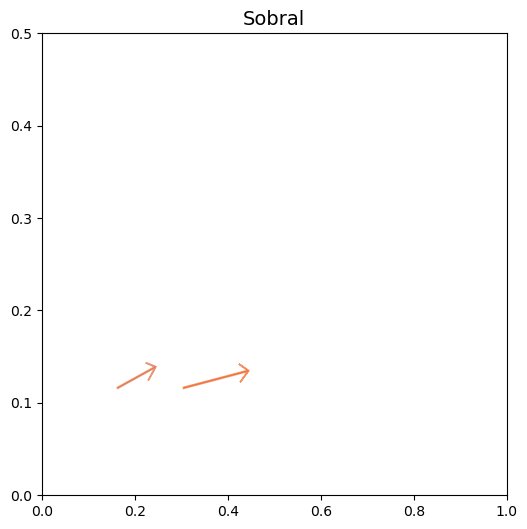

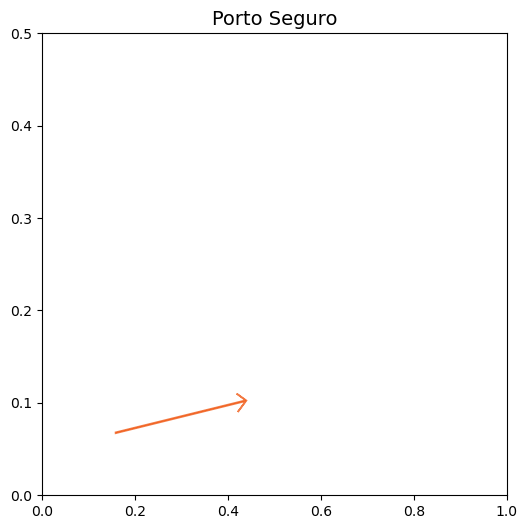

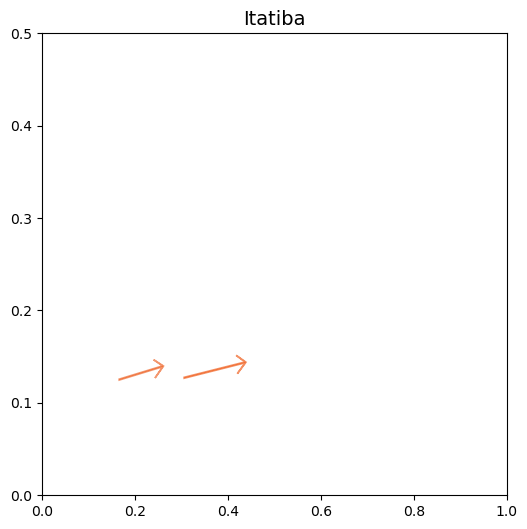

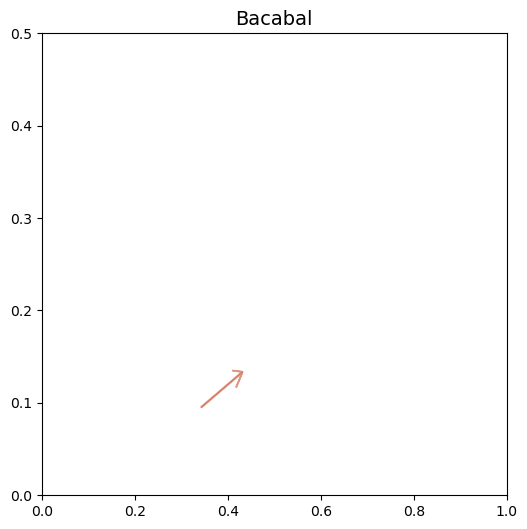

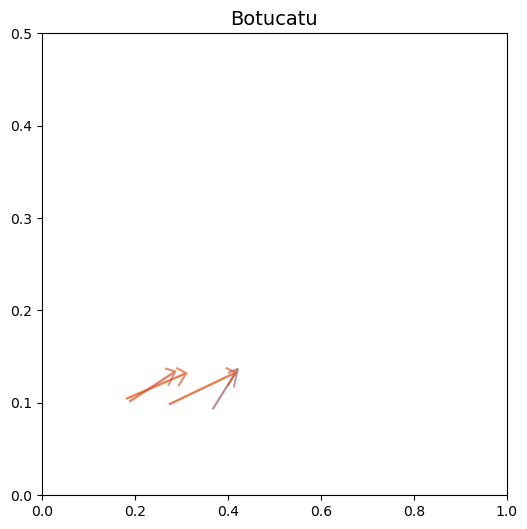

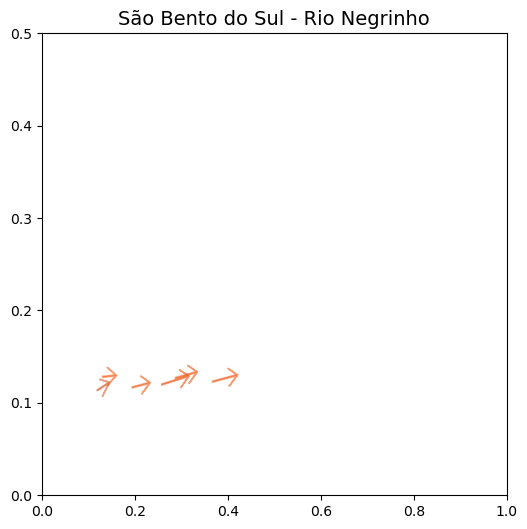

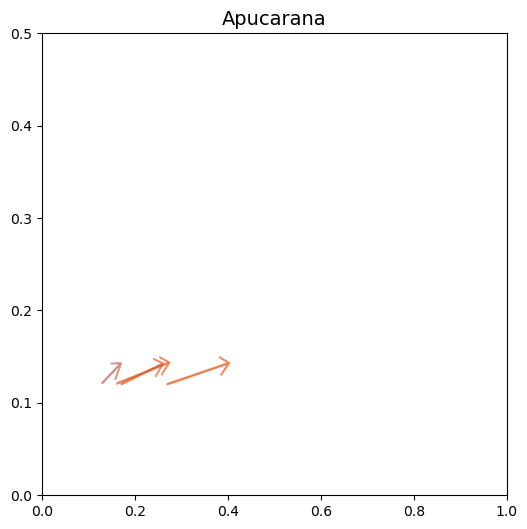

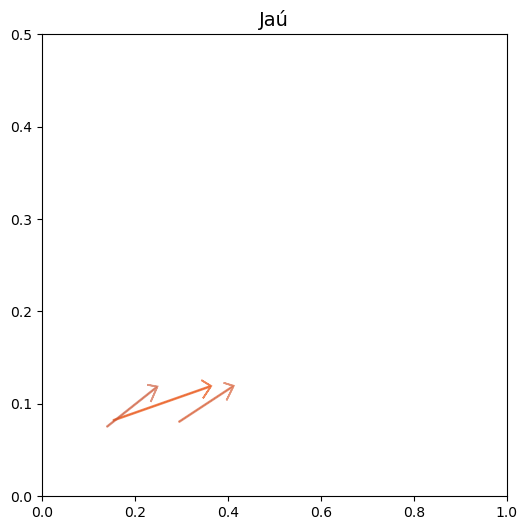

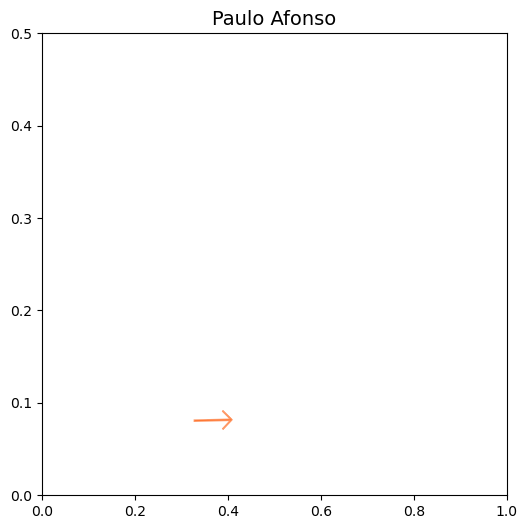

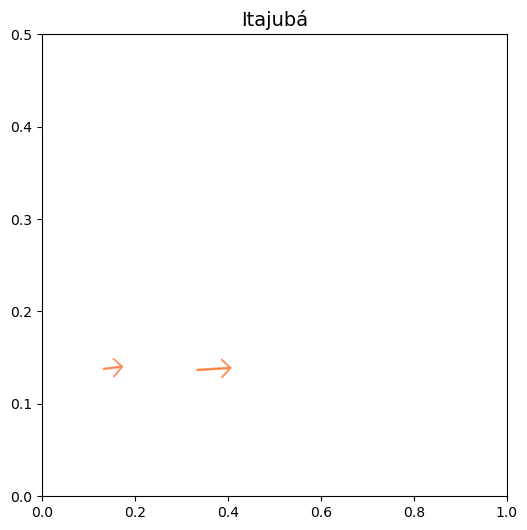

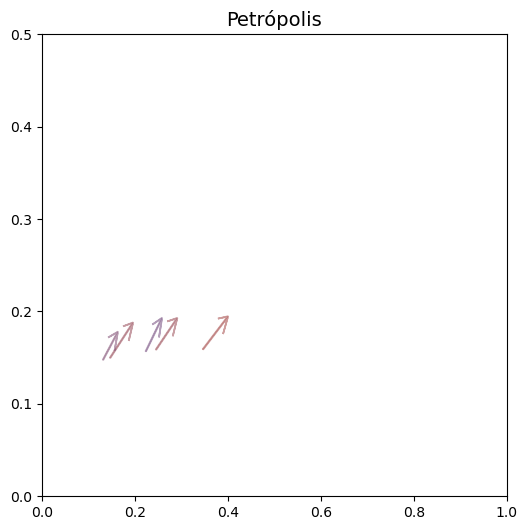

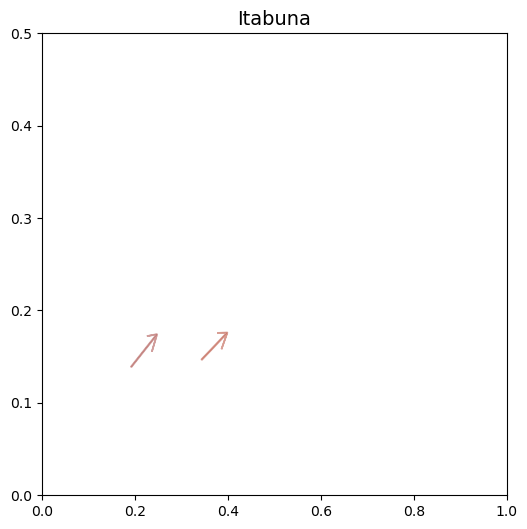

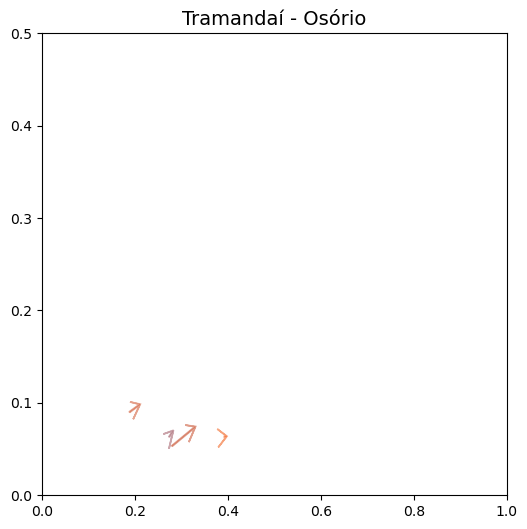

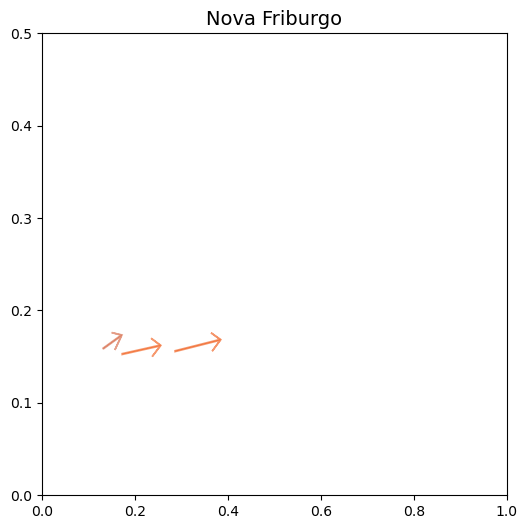

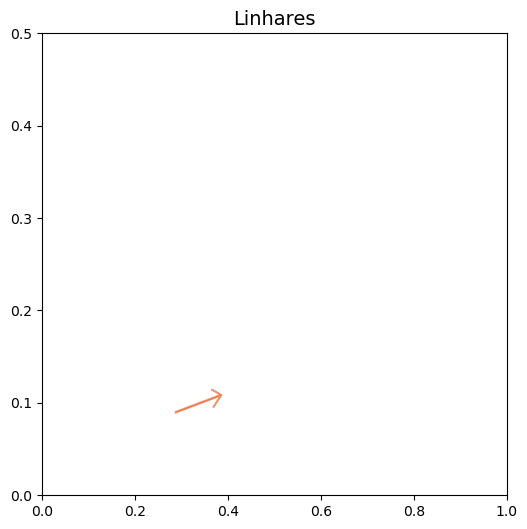

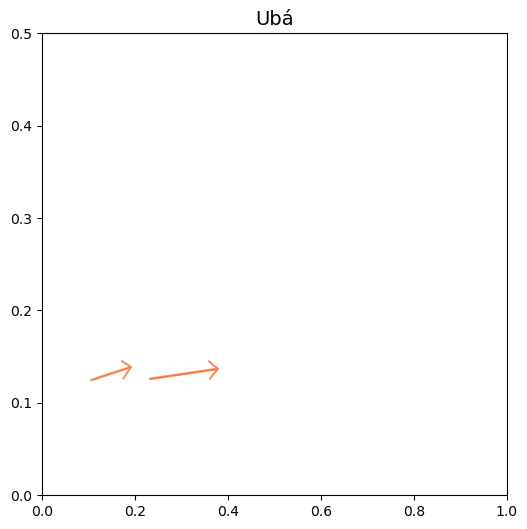

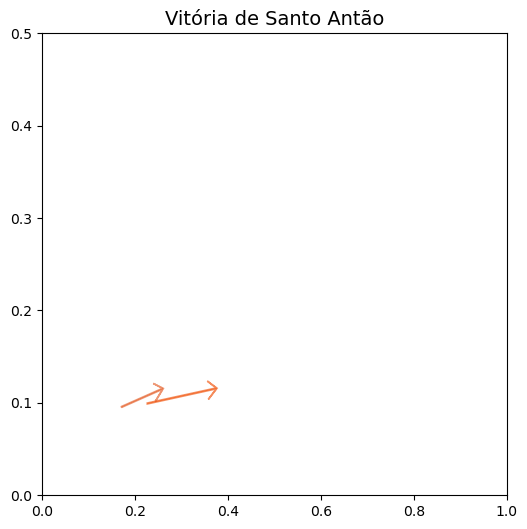

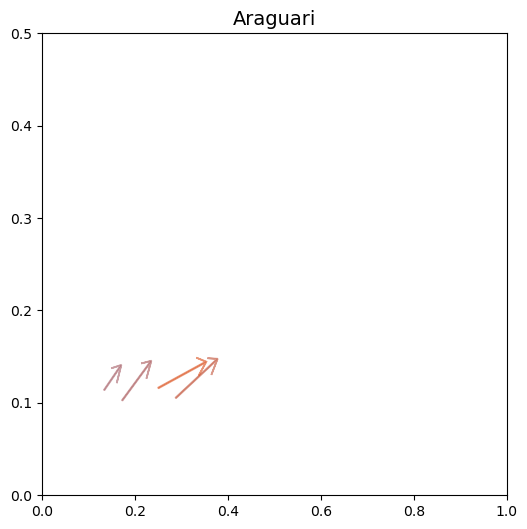

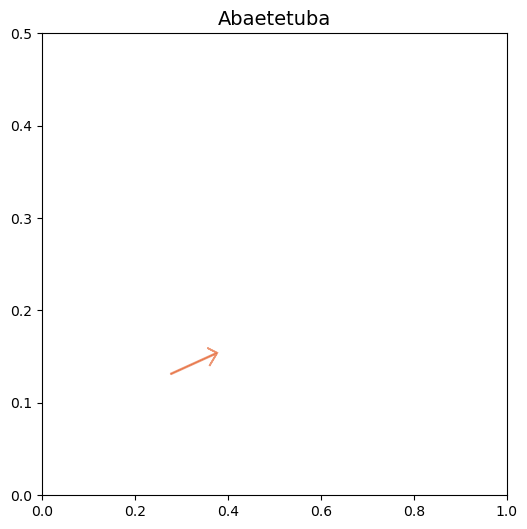

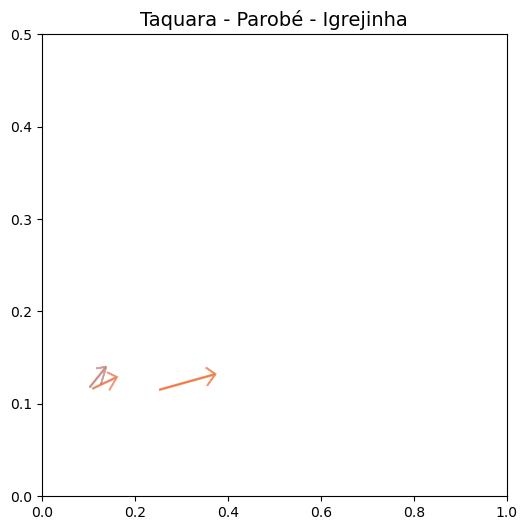

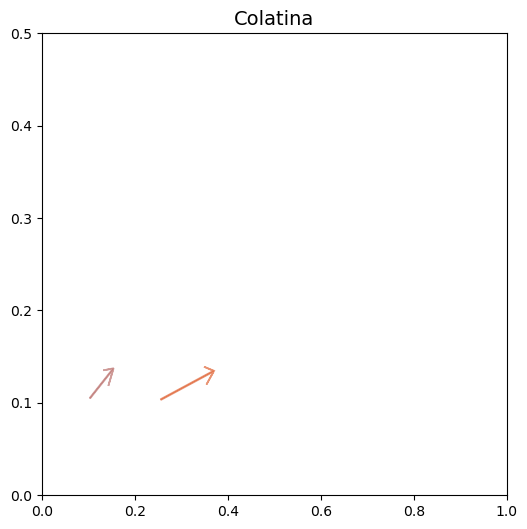

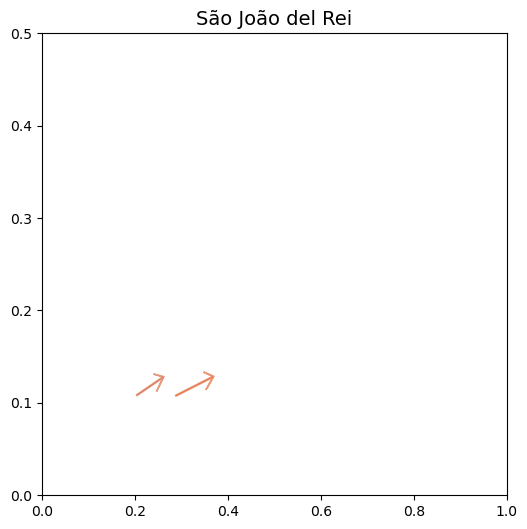

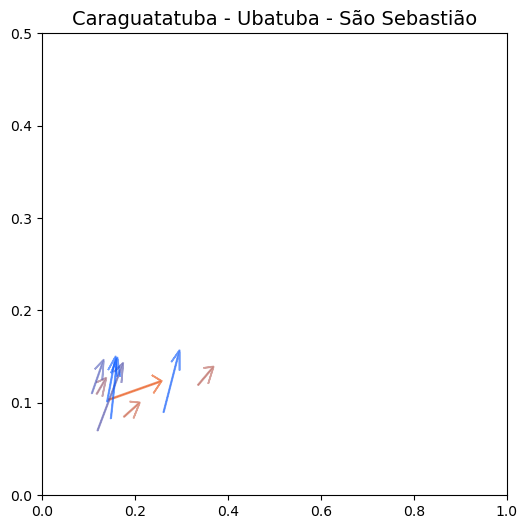

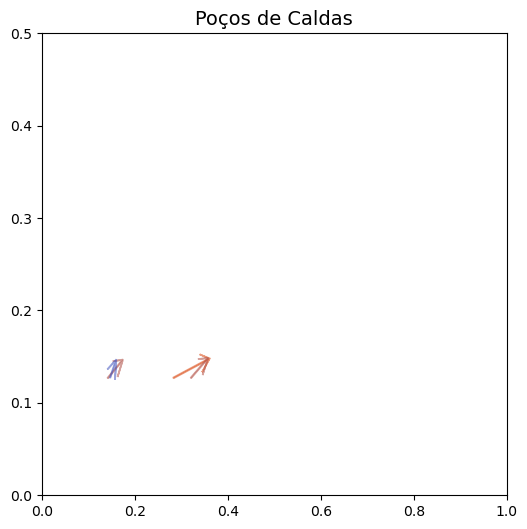

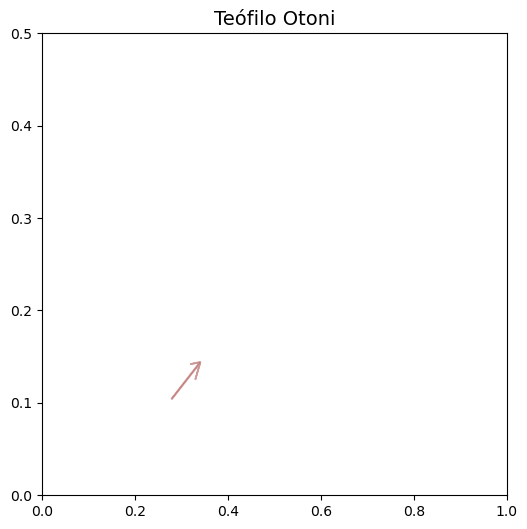

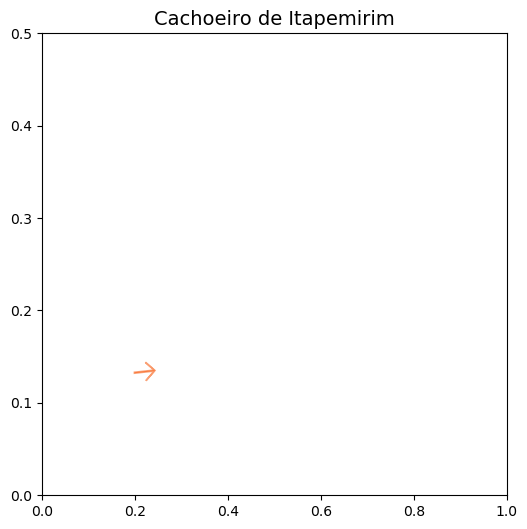

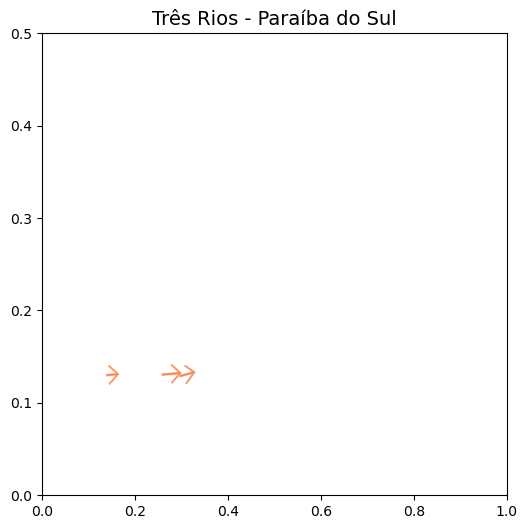

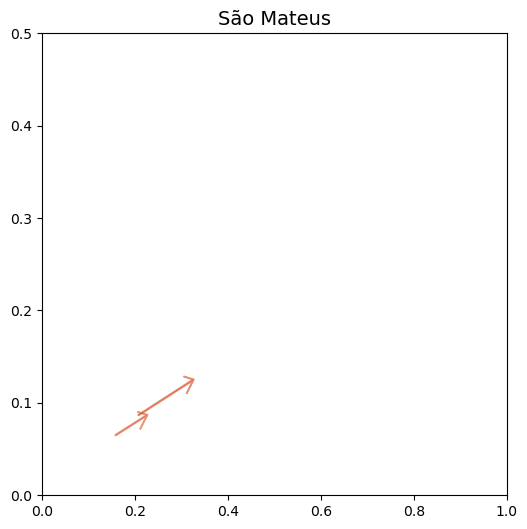

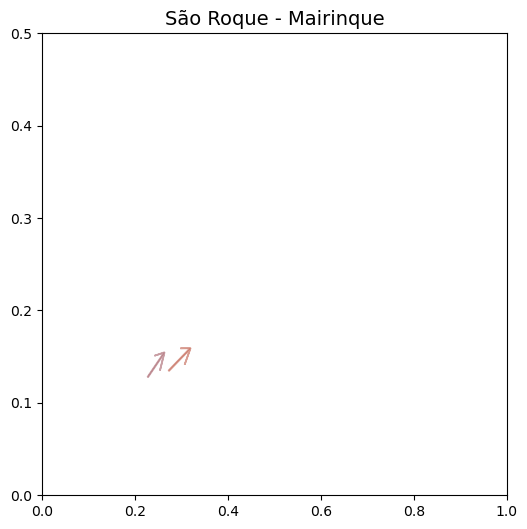

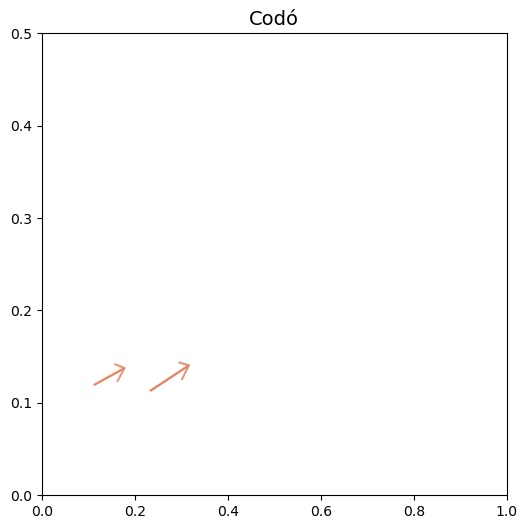

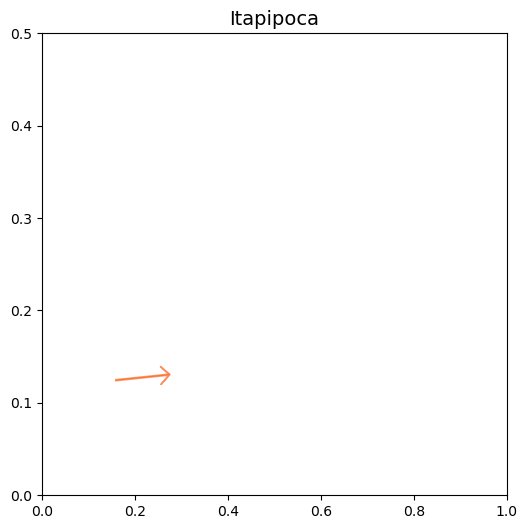

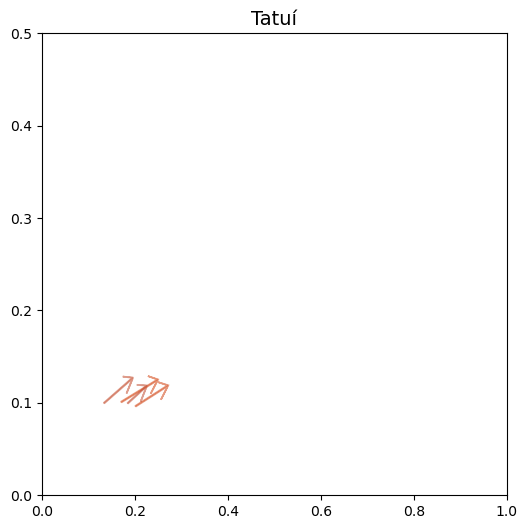

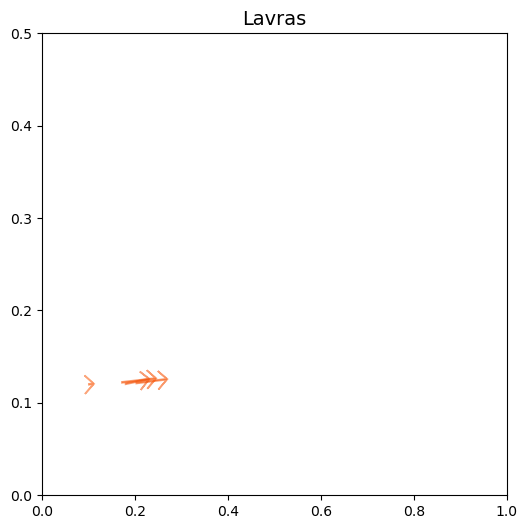

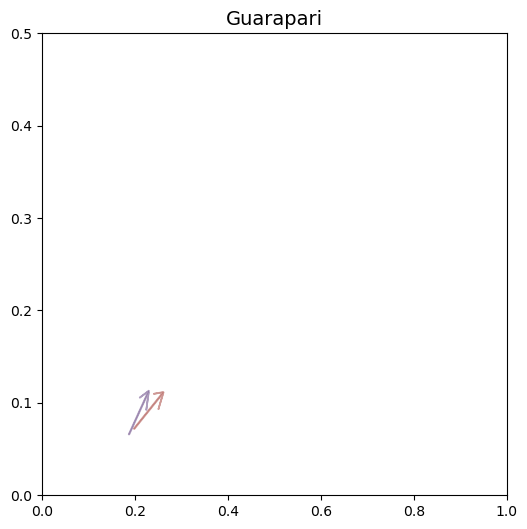

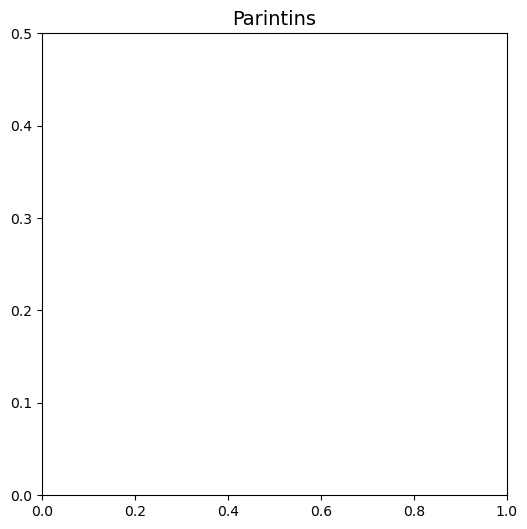

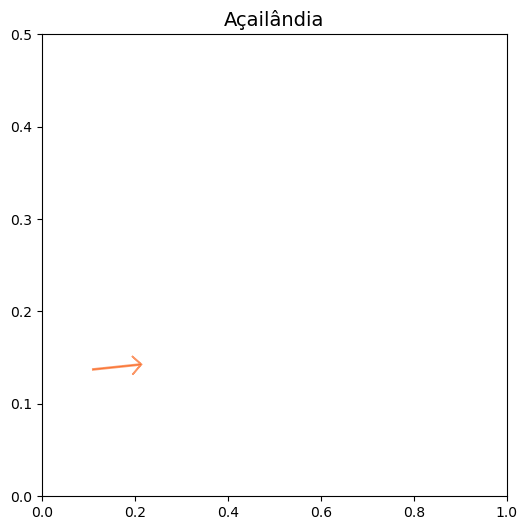

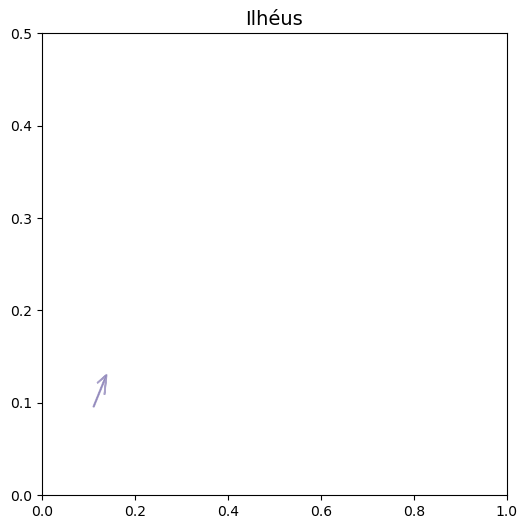

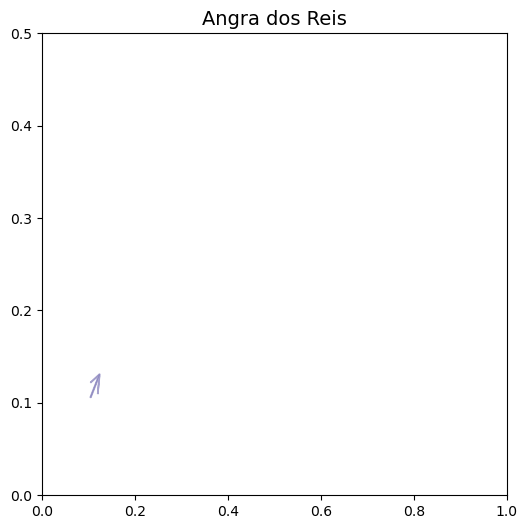

In [6]:
#Import height stats from previous steps
allstats = gpd.read_file('_raw_data/heightzonalstats/all_sats_stats.shp')

#Consider to be urban only the pixels covered by at least 10% or urbanized land
urbano = allstats[allstats['urban']>0.1]

#We'll generate an arrow chart for each urban concentration in the raw file
for cidade in pd.unique(urbano['_nm_concur']):
    escolhida = urbano[urbano['_nm_concur']==cidade]
    
    #Data wrangling to get the right names and number of fields
    vertfields = []
    vert=[]
    for year in range(1993,2020):
        vertfields.append('h_'+str(year))

    for row in range(0,len(escolhida)):
        vert.append([0])
        for n in range(0,len(vertfields)-1):
            vert[row].append(0)

    for row in range(0,len(escolhida)):
        for n in range(0,len(vertfields)):
            vert[row][n]=escolhida.iloc[row][vertfields[n]]
            
    horzfields = ['urban']
    horz=[]
    for year in range(1994,2020):
        horzfields.append('urban_'+str(year))

    for row in range(0,len(escolhida)):
        horz.append([0])
        for n in range(0,len(horzfields)-1):
            horz[row].append(0)

    for row in range(0,len(escolhida)):
        for n in range(0,len(horzfields)):
            horz[row][n]=escolhida.iloc[row][horzfields[n]]
    
    #Matplotlib configuration
    f = plt.figure(figsize=(6,6))
    ax = plt.axes()
    
    #We'll want to color each arrow accordingly to it's direction (inclination, or slope)
    def slopee(x1,y1,x2,y2):
            x = (y2 - y1) / (x2 - x1)
            return x
        

    cmap = palette.mpl_colormap

    cNorm  = colors.Normalize(vmin=0, vmax=2)

    scalarMap = cm.ScalarMappable(norm=cNorm,cmap=cmap)


    for column in range(0,len(horz)):
        
        x = np.array(horz[column])
        y = np.array(vert[column])
        
        #LINEAR TRENDLINE
        # 1   LINEAR
        # >=2 POLINOMIAL
        z = np.polyfit(horz[column], vert[column], 1)
        p = np.poly1d(z)
        
        #We'll want to change an arrow opacity's based on how long it is
        def calculateDistance(x1,y1,x2,y2):
            dist = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            return dist
        maxdist = calculateDistance(0,0,0,0.55)
        mindist = calculateDistance(0,0,0,0)
        
        slope = slopee(horz[column][0],p(horz[column])[0],horz[column][-1],p(horz[column])[-1])
        
        #Keep only positive values (cells with declining urban tissue are most likely errors in the source data)
        if slope >=0:
            colorVal = scalarMap.to_rgba(slope)
            transparency = (calculateDistance(horz[column][0],p(horz[column])[0],horz[column][-1],p(horz[column])[-1])-mindist)/(maxdist-mindist)
            transparency = (0.5*transparency) + 0.5
            plt.arrow(x=horz[column][0],y=p(horz[column])[0],dx=(horz[column][-1]-horz[column][0]),dy=(p(horz[column])[-1]-p(horz[column])[0]), shape='full',
                      length_includes_head=True, head_starts_at_zero=False, lw=1.2, head_width=.02, head_length=0.02, overhang = 0.9, color=colorVal,
                      alpha=transparency)

        
                
        #FIG SETTINGS
        plt.xlim([0, 1])
        plt.ylim([0,0.5])
        ax.set_title(cidade,fontsize = 14)
    
    #plt.close(f)




# Cluster analysis at pixel level
## Horizontal, vertical and population growth

In [10]:
#Read the processed data from last step
allstats = gpd.read_file('_raw_data/heightzonalstats/all_sats_stats_with_pop.shp')
allstats['vert_change']=allstats['h_2020']-allstats['h_1993']
allstats['horz_change']=allstats['urban_2020']-allstats['urban']
allstats['pop_change']=(allstats['pop_2020']-allstats['pop_1993'])/300000

#Consider only pixels covered by at least 10% urbanized area and at least 0.01 PR in 1993 to avoid false positives
urbano = allstats[allstats['urban']>0.1]
urbano = urbano[urbano['h_1993']>0.01]

Text(0, 0.5, 'Mudança na ocupação vertical (PR)')

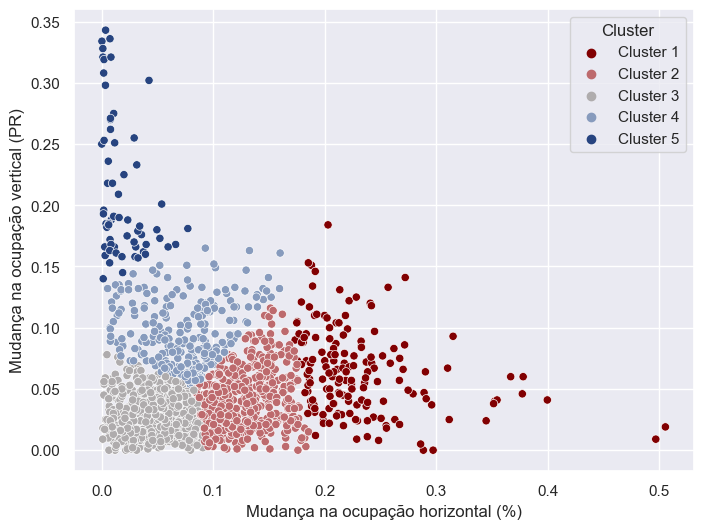

In [21]:
#Set up seaborn figure size
sns.set(rc={'figure.figsize':(8,6)})

#We'll use a k-means clustering model that looks for groups in the distribution of horizontal and vertical total change in all pixels
X = urbano[['horz_change', 'vert_change']].copy()
sns.set()
#Kmeans set up
kmeans = KMeans(n_clusters=5, random_state=0)
#Get the labels back and rename them so the "Stable" class is the middle one (3)
X['label']=kmeans.fit(X).labels_
X['Cluster'] = X['label'].replace({0: 'Cluster 3', 1: 'Cluster 2', 2: 'Cluster 4', 3: 'Cluster 5', 4: 'Cluster 1'})
#Ignore negative change in both axis
X = X.loc[X['vert_change']>=0]
X = X.loc[X['horz_change']>=0]
#Set up a scatterplot to visualize the distribution of clusters in both axis
chart = sns.scatterplot(x=X['horz_change'], y=X['vert_change'], hue=X['Cluster'], hue_order = ['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5'], palette=['#810002','#BD6A6D','#AFACAD','#879BBD','#274480'])
chart.set_xlabel("Mudança na ocupação horizontal (%)")
chart.set_ylabel("Mudança na ocupação vertical (PR)")

In [22]:
#Clean up further the underlying data to remove any negative value change
urb = urbano.copy()
urb = urb.loc[urb['vert_change']>=0]
urb = urb.loc[urb['horz_change']>=0]
urb = urb.loc[urb['pop_change']>=0]
#Get the labels from the k-means cluster analysis into the original dataset
urb = urb.merge(X[['Cluster']], left_index=True, right_index=True)

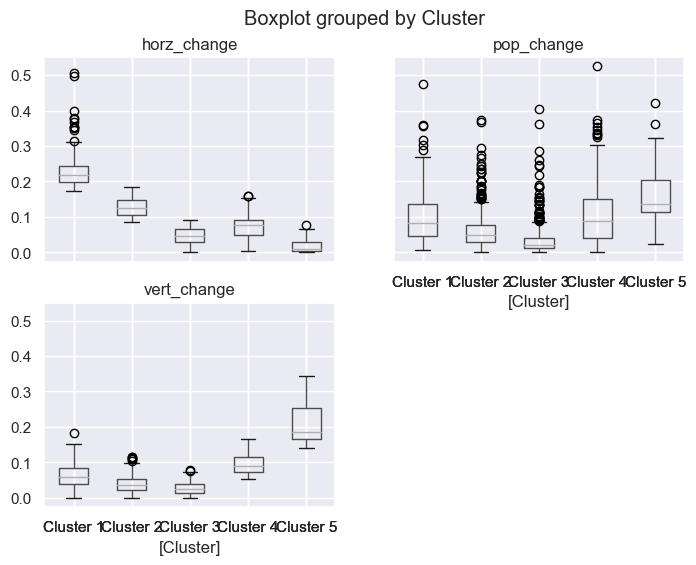

In [23]:
#Investigate the variation of change in each growth axis with box plots
boxplot = urb[['pop_change','vert_change','horz_change', 'Cluster']].boxplot(by='Cluster')

In [152]:
#Export results
urb.to_file('Growth_and_cluster_by_pixel.gpkg')

# Bar charts
## And overall cluster distribution

In [25]:
#Get the distribution of pixels in each cluster
pixel_per_cluster = urb['Cluster'].value_counts()
pixel_per_cluster = pixel_per_cluster/sum(pixel_per_cluster)
pixel_per_cluster = pixel_per_cluster.sort_index()
pixel_per_cluster

Cluster 1    0.104818
Cluster 2    0.304688
Cluster 3    0.389974
Cluster 4    0.159505
Cluster 5    0.041016
Name: Cluster, dtype: float64

<AxesSubplot:>

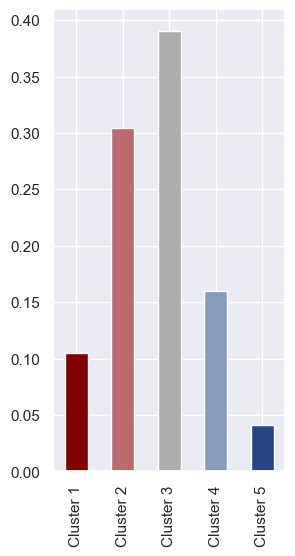

In [27]:
pixel_per_cluster.plot.bar(stacked=True, figsize=(3, 6), color=['#810002','#BD6A6D','#AFACAD','#879BBD','#274480'])

In [28]:
#Get the distribution of population change in each cluster
pop_ch_per_cluster = urb.groupby(["Cluster"])["pop_change"].sum()
pop_ch_per_cluster = pop_ch_per_cluster/sum(pop_ch_per_cluster)
pop_ch_per_cluster = pop_ch_per_cluster.sort_index()
pop_ch_per_cluster

Cluster
Cluster 1    0.161296
Cluster 2    0.286152
Cluster 3    0.203115
Cluster 4    0.252300
Cluster 5    0.097137
Name: pop_change, dtype: float64

<AxesSubplot:xlabel='Cluster'>

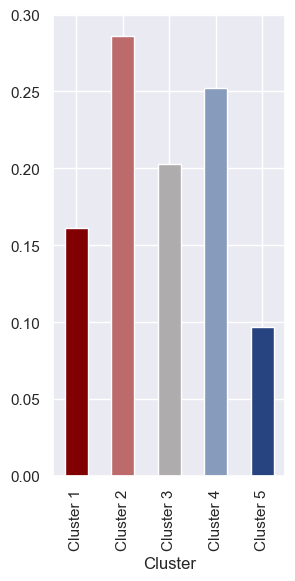

In [29]:
pop_ch_per_cluster.plot.bar(stacked=True, figsize=(3, 6), color=['#810002','#BD6A6D','#AFACAD','#879BBD','#274480'])

# Cluster analysis at urban concentration level
## Horizontal, vertical and population growth

In [36]:
#Get data on urban concentrations
munurb = gpd.read_file('_raw_data/IBGE_Areas Urbanas/IBGE_AreasUrbanas_Municipios.shp')

In [44]:
#Rename clusters for enhanced clarity
urb['label'] = urb['Cluster'].replace({'Cluster 1': 'Cluster 1 - High outward growth', 'Cluster 2': 'Cluster 2 - Incremental outward growth', 'Cluster 3': 'Cluster 3 - Very low urban growth', 'Cluster 5': 'Cluster 5 - High upward growth', 'Cluster 4': 'Cluster 4 - Incremental upward growth'})


In [45]:
#Put it all together
final = urbano.merge(munurb.drop_duplicates('cd_concurb')[['cd_concurb','nm_concurb']], left_on='_cd_concur', right_on='cd_concurb', how='inner')
final = urb[['index','label']].merge(final, on='index')
final

index                              label  id  index_righ     urban  \
0     270651.0     Cluster 5 - High upward growth   1         0.0  1.000000   
1     270436.0     Cluster 5 - High upward growth   1         0.0  0.998256   
2     271075.0     Cluster 5 - High upward growth   1         0.0  0.988400   
3     270650.0     Cluster 5 - High upward growth   1         0.0  0.998247   
4     270218.0     Cluster 5 - High upward growth   1         0.0  0.994156   
...        ...                                ...  ..         ...       ...   
1531  256290.0  Cluster 3 - Very low urban growth   1         0.0  0.101052   
1532  272675.0  Cluster 3 - Very low urban growth   1         0.0  0.102758   
1533  288638.0  Cluster 3 - Very low urban growth   1         0.0  0.100891   
1534  190253.0  Cluster 3 - Very low urban growth   1         0.0  0.107989   
1535  111571.0  Cluster 3 - Very low urban growth   1         0.0  0.105362   

      urban_1994  urban_1995  urban_1996  urban_1997  urban_1998  ...  \
0       1.000000    1.000000    1.000000    1.000000    1.000000  ...   
1       0.998256    0.998431    0.998692    0.998779    0.999128  ...   
2       0.989569    0.993251    0.994332    0.995150    0.995150  ...   
3       0.998247    0.998335    0.999123    0.999123    0.999123  ...   
4       0.994273    0.995033    0.995296    0.996085    0.997107  ...   
...          ...         ...         ...         ...         ...  ...   
1531    0.101861    0.101861    0.102006    0.102382    0.103191  ...   
1532    0.102700    0.104087    0.104839    0.105995    0.107816  ...   
1533    0.101066    0.101388    0.101972    0.102264    0.103053  ...   
1534    0.108105    0.108076    0.108163    0.108018    0.108192  ...   
1535    0.106121    0.106706    0.106560    0.106589    0.106618  ...   

        pop_2017    pop_2018    pop_2019    pop_2020  \
0     342462.624  343426.322  344390.020  345353.720   
1     386513.067  387599.640  388686.213  389772.786   
2     261088.824  261916.478  262744.132  263571.786   
3     279653.470  280443.383  281233.296  282023.207   
4     371814.746  373213.767  374612.788  376011.808   
...          ...         ...         ...         ...   
1531    5046.707    5074.353    5101.999    5129.644   
1532   11411.893   11627.935   11843.977   12060.019   
1533   11049.457   11134.440   11219.423   11304.404   
1534   40100.295   40340.020   40579.745   40819.472   
1535    5805.527    5798.580    5791.633    5784.688   

                                               geometry  vert_change  \
0     POLYGON ((-46.55000 -23.60000, -46.55000 -23.5...        0.250   
1     POLYGON ((-46.50000 -23.55000, -46.50000 -23.5...        0.196   
2     POLYGON ((-46.60000 -23.70000, -46.60000 -23.6...        0.251   
3     POLYGON ((-46.60000 -23.60000, -46.60000 -23.5...        0.308   
4     POLYGON ((-46.60000 -23.50000, -46.60000 -23.4...        0.218   
...                                                 ...          ...   
1531  POLYGON ((-44.95000 -21.20000, -44.95000 -21.1...        0.004   
1532  POLYGON ((-46.65000 -24.10000, -46.65000 -24.0...        0.056   
1533  POLYGON ((-51.00000 -30.00000, -51.00000 -29.9...        0.019   
1534  POLYGON ((-38.55000 -12.95000, -38.55000 -12.9...        0.056   
1535  POLYGON ((-36.00000 -7.15000, -36.00000 -7.100...        0.017   

      horz_change  pop_change  cd_concurb           nm_concurb  
0        0.000000    0.167379     3550308         S�o Paulo/SP  
1        0.001744    0.188958     3550308         S�o Paulo/SP  
2        0.011600    0.132716     3550308         S�o Paulo/SP  
3        0.001753    0.136777     3550308         S�o Paulo/SP  
4        0.005230    0.206123     3550308         S�o Paulo/SP  
...           ...         ...         ...                  ...  
1531     0.012978    0.005236     3138203            Lavras/MG  
1532     0.009250    0.018917     3548500  Baixada Santista/SP  
1533     0.009379    0.010835     4314902      Porto Alegre/

In [46]:
#Count the number of pixels in each cluster
final['cluster_1']=0
final['cluster_2']=0
final['cluster_3']=0
final['cluster_4']=0
final['cluster_5']=0

final.loc[final["label"] == "Cluster 1 - High outward growth", "cluster_1"] = 1
final.loc[final["label"] == "Cluster 2 - Incremental outward growth", "cluster_2"] = 1
final.loc[final["label"] == "Cluster 3 - Very low urban growth", "cluster_3"] = 1
final.loc[final["label"] == "Cluster 4 - Incremental upward growth", "cluster_4"] = 1
final.loc[final["label"] == "Cluster 5 - High upward growth", "cluster_5"] = 1

In [47]:
#Now let's group by urban concentration to get the total sum of pixels from each cluster
agregado = final.groupby(['nm_concurb']).agg({'vert_change':sum, 'horz_change':sum, 'nm_concurb':'count', 'cluster_1':sum, 'cluster_2':sum, 'cluster_3':sum, 'cluster_4':sum, 'cluster_5':sum}).rename(columns={'nm_concurb':'pixel_count', 'vert_change':'UGI', 'horz_change':'OGI'}).reset_index()
agregado

nm_concurb    UGI       OGI  pixel_count  \
0                              Abaetetuba  0.030  0.106544            1   
1                              Alagoinhas  0.080  0.144255            2   
2    Americana - Santa B�rbara d�Oeste/SP  0.553  0.924908            9   
3                          Angra dos Reis  0.029  0.020721            1   
4                                An�polis  0.312  0.715389            7   
..                                    ...    ...       ...          ...   
174                              Varginha  0.043  0.221463            2   
175                  Vit�ria da Conquista  0.101  0.803425            4   
176                Vit�ria de Santo Ant�o  0.058  0.256587            2   
177                            Vit�ria/ES  1.471  1.377508           25   
178        Volta Redonda - Barra Mansa/RJ  0.271  0.267165           10   

     cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  
0            0          1          0          0          0  
1            0          1          1          0          0  
2            0          4          1          4          0  
3            0          0          1          0          0  
4            0          3          4          0          0  
..         ...        ...        ...        ...        ...  
174          0          1          1          0          0  
175          2          2          0          0          0  
176          0          2          0          0          0  
177          1          2         11         11          0  
178          0          0         10          0          0  

[179 rows x 9 columns]

In [48]:
#Transform the absolute counts in proportions for each urban concentration
agregado['cluster_1'] = agregado['cluster_1']/agregado['pixel_count']
agregado['cluster_2'] = agregado['cluster_2']/agregado['pixel_count']
agregado['cluster_3'] = agregado['cluster_3']/agregado['pixel_count']
agregado['cluster_4'] = agregado['cluster_4']/agregado['pixel_count']
agregado['cluster_5'] = agregado['cluster_5']/agregado['pixel_count']

In [51]:
#We'll run a new k-means clustering operation to classify each urban concentration
#Accordingly to its pixel's cluster distribution and total pixel count
#We'll attempt to find 5 clusters, much like what was done at the pixel level

#Keep only needed fields
X=agregado.drop(["nm_concurb","UGI","OGI"],axis=1)
X['pixel_count']=(X['pixel_count']-1)/(125-1)

#Feed the model
kmeans = KMeans(
        n_clusters=5, init="k-means++",
        n_init=10,
        tol=1e-04, random_state=42
    )
#Fit data to the model
kmeans.fit(X)

#Make it a dataframe
clusters=pd.DataFrame(X,columns=agregado.drop(["nm_concurb","UGI","OGI"],axis=1).columns)
clusters['label']=kmeans.labels_

#This time we have more than two variables' variations going into each cluster
#So a polar (spider) chart is better than a scatterplot to see the distribution of the results
polar=clusters.groupby("label").mean().reset_index()
polar=pd.melt(polar,id_vars=["label"])
fig4 = px.line_polar(polar, r="value", theta="variable", color="label", line_close=True,height=600,width=1000)
fig4.show()


#0 Expansão horizontal - estável
#1 Estável
#2 Expansão horizontal extrema
#3 Expansão horizontal moderada
#4 Processo contínuo de verticalização

In [54]:
#Add the new classes to the original dataframe
agregado['classe_expansao']=kmeans.labels_

In [84]:
#Class number 0 (Horizontal/stable expansion) doesn't seem to be particularly unique, and behaves more like 
#a class in between moderate horizontal expansion (3) and stable (1)
#So we'll get rid of it by merging it to these two classes in accordance to the preponderance of pixels in cluster 3 (Stable) or 2 (Moderate horizontal)
agregado.loc[(agregado['classe_expansao']==0)&(agregado['cluster_3']>agregado['cluster_2']), 'classe_expansao']=1
agregado.loc[(agregado['classe_expansao']==0)&(agregado['cluster_3']<agregado['cluster_2']), 'classe_expansao']=3
agregado.loc[(agregado['classe_expansao']==0)&(agregado['cluster_3']==agregado['cluster_2']), 'classe_expansao']=1


In [93]:
#Get the geographic boundaries of all urban concentrations
lims = gpd.read_file('_raw_data/IBGE_Areas Urbanas/IBGE_AreasUrbanas_Limites.shp')

In [87]:
#Add the cluster and expansion information into the geographic boundaria geodataframa
limstats=agregado.merge(lims,how='left',left_on='nm_concurb', right_on='nm_concurb')

In [88]:
#Codes for the new classes so we can rename them accordingly
#1 Estável
#2 Expansão horizontal extrema
#3 Expansão horizontal moderada
#4 Processo contínuo de verticalização
limstats['classe_expansao'] = limstats['classe_expansao'].replace({1: 'Estável', 2: 'Expansão horizontal extrema', 3: 'Expansão horizontal moderada', 4: 'Processo contínuo de verticalização'})

In [89]:
#Put it all together
statsbyconcurb = limstats.merge(munurb.drop_duplicates('cd_concurb').drop(['cd_recorte', 'quadro', 'nm_concurb', 'cd_mun','nm_mun','geometry'], axis=1), how='left', on='cd_concurb')

In [91]:
#Get the new distribution of urban concentrations by class
print('Estável:'+str(len(statsbyconcurb[statsbyconcurb['classe_expansao']=='Estável'])))
print('Processo contínuo de verticalização:'+str(len(statsbyconcurb[statsbyconcurb['classe_expansao']=='Processo contínuo de verticalização'])))
print('Expansão horizontal extrema:'+str(len(statsbyconcurb[statsbyconcurb['classe_expansao']=='Expansão horizontal extrema'])))
print('Expansão horizontal moderada:'+str(len(statsbyconcurb[statsbyconcurb['classe_expansao']=='Expansão horizontal moderada'])))

Estável:82
Processo contínuo de verticalização:19
Expansão horizontal extrema:31
Expansão horizontal moderada:47


In [92]:
#Visualize the spider chart with the updated classes (4 as opposed to 5)
X=statsbyconcurb.drop(["nm_concurb","UGI","OGI","cd_recorte","quadro","cd_concurb","area","estado","amazonia","geometry"],axis=1)
X['pixel_count']=(X['pixel_count']-1)/(125-1)
clusters=pd.DataFrame(X,columns=statsbyconcurb.drop(["nm_concurb","UGI","OGI","cd_recorte","quadro","cd_concurb","area","estado","amazonia","geometry"],axis=1).columns)

polar=clusters.groupby("classe_expansao").mean().reset_index()
polar=pd.melt(polar,id_vars=["classe_expansao"])
fig4 = px.line_polar(polar, r="value", theta="variable", color="classe_expansao", line_close=True,height=600,width=1000)
fig4.show()

# Stacked bar charts
## Pixel cluster distribution by class of urban concentration

In [103]:
concurbstats = pd.merge(final,statsbyconcurb[['cd_concurb','classe_expansao', 'pixel_count']],on='cd_concurb', how='left')
concurbstats = concurbstats.sort_values('pixel_count')

In [120]:
unstacked = concurbstats.groupby('_nm_concur')['label'].value_counts().unstack()
unstacked['nm_concurb']=unstacked.index
unstacked = pd.merge(unstacked,concurbstats[['_nm_concur','pixel_count','classe_expansao', 'label']],left_on='nm_concurb',right_on='_nm_concur',how='left')
unstacked = unstacked.drop_duplicates().sort_values('pixel_count')
unstacked = unstacked.drop(['pixel_count'],axis=1)
unstacked.index = unstacked['nm_concurb']
unstacked = unstacked[~unstacked.index.duplicated(keep='first')]

In [122]:
unstacked = unstacked[['Cluster 3 - Very low urban growth','Cluster 2 - Incremental outward growth','Cluster 1 - High outward growth','Cluster 4 - Incremental upward growth','Cluster 5 - High upward growth','classe_expansao','label','nm_concurb','_nm_concur']]

<AxesSubplot:ylabel='nm_concurb'>

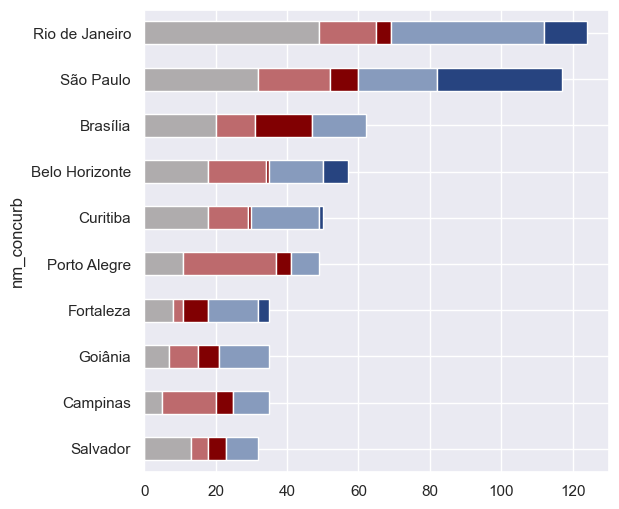

In [123]:
unstacked[unstacked['classe_expansao']=='Processo contínuo de verticalização'][-10:].plot.barh(stacked=True, legend=False, figsize=(6, 6), color=['#AFACAD','#BD6A6D','#810002','#879BBD','#274480'])

<AxesSubplot:ylabel='nm_concurb'>

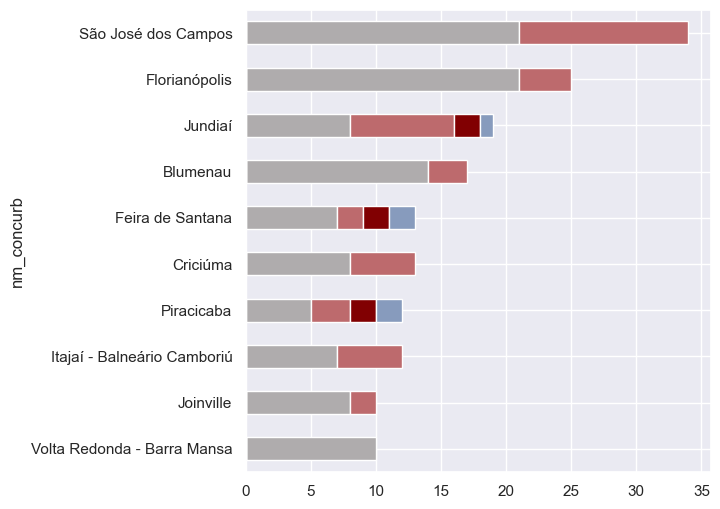

In [124]:
unstacked[unstacked['classe_expansao']=='Estável'][-10:].plot.barh(stacked=True, legend=False, figsize=(6, 6), color=['#AFACAD','#BD6A6D','#810002','#879BBD','#274480'])

<AxesSubplot:ylabel='nm_concurb'>

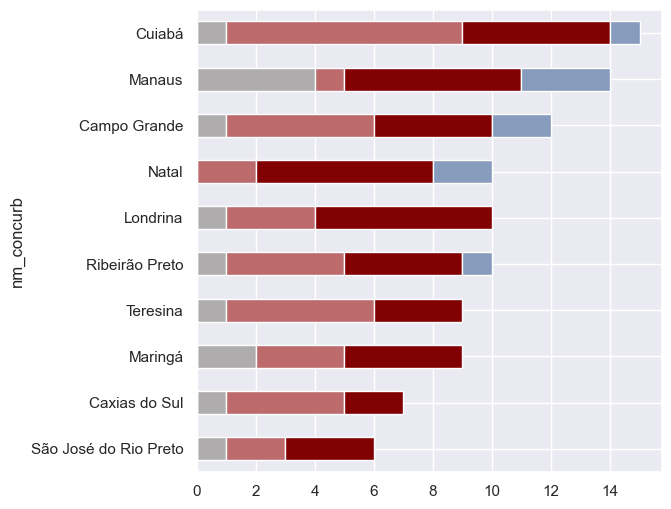

In [125]:
unstacked[unstacked['classe_expansao']=='Expansão horizontal extrema'][-10:].plot.barh(stacked=True, legend=False, figsize=(6, 6), color=['#AFACAD','#BD6A6D','#810002','#879BBD','#274480'])

<AxesSubplot:ylabel='nm_concurb'>

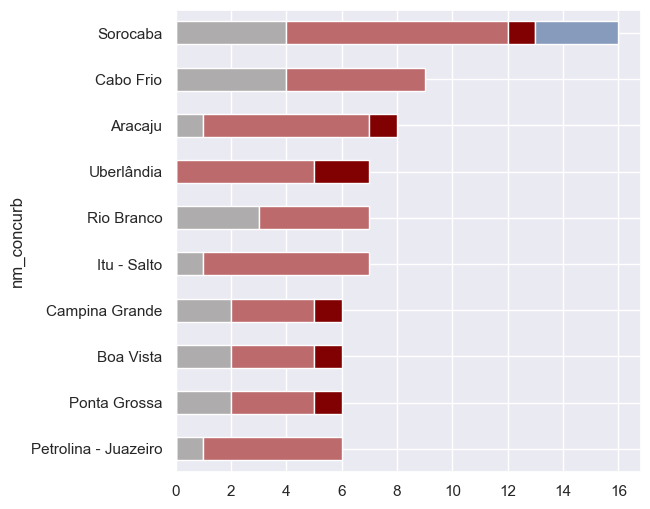

In [126]:
unstacked[unstacked['classe_expansao']=='Expansão horizontal moderada'][-10:].plot.barh(stacked=True, legend=False,figsize=(6, 6), color=['#AFACAD','#BD6A6D','#810002','#879BBD','#274480'])

# National map
## A display of urban concentrations by expansion class

In [146]:
#Take the data and create a geodataframe with centroids as geometries
muncenters = gpd.GeoDataFrame(limstats, geometry=limstats.geometry)
muncenters = gpd.GeoDataFrame(limstats, geometry=teste.centroid).set_crs(4326)

/Users/guilhermeiablonovski/opt/anaconda3/envs/geopandasenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




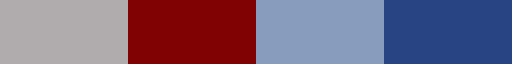

In [147]:
#Establish a palette in a cmap for the map
cityPalette = {'Estável': '#AFACAD',
               'Expansão horizontal extrema': '#810002',
               'Expansão horizontal moderada': '#879BBD',
               'Processo contínuo de verticalização': '#274480'}

cmap = colors.ListedColormap([cityPalette[b] for b in concurbstats.classe_expansao.unique()])
cmap

/Users/guilhermeiablonovski/opt/anaconda3/envs/geopandasenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




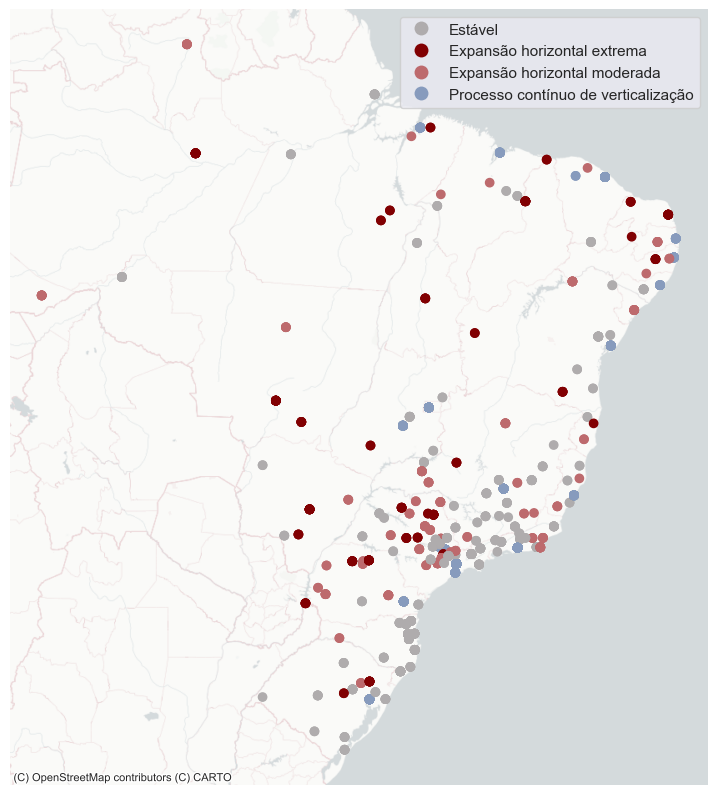

In [148]:
#1 Estável
#2 Expansão horizontal extrema
#3 Expansão horizontal moderada
#4 Expansão vertical balanceada
centroid = gpd.GeoDataFrame(munurb, geometry=munurb.centroid)
cityPalette = {'Estável': '#AFACAD',
               'Expansão horizontal moderada': '#BD6A6D',
               'Expansão horizontal extrema': '#810002',
               'Processo contínuo de verticalização': '#879BBD'}

cmap = colors.ListedColormap([cityPalette[b] for b in concurbstats.classe_expansao.unique()])
mapa = muncenters.merge(concurbstats[['classe_expansao','cd_concurb']], left_on='cd_concurb', right_on='cd_concurb', how='left').to_crs('EPSG:3857').plot(column='classe_expansao_x', figsize=(9, 35), legend=True, cmap=cmap)
cx.add_basemap(mapa, source=cx.providers.CartoDB.PositronNoLabels)
mapa.set_axis_off()

In [151]:
#Export results
statsbyconcurb.to_excel('stats_by_concurb.xlsx')

# Growth rate charts

In [153]:
tendencia = pd.read_excel('_raw_data/heightzonalstats/national_ugi_ogi_pop.xlsx')

In [154]:
tendencia['horz_taxa_crescimento'] = tendencia['horizontal'].pct_change(periods=2) * 100
tendencia['vert_taxa_crescimento'] = tendencia['vertical'].pct_change(periods=2) * 100
tendencia['form_taxa_crescimento'] = tendencia['form'].pct_change(periods=2) * 100
tendencia['pop_taxa_crescimento'] = tendencia['population'].pct_change(periods=2) * 100

In [155]:
coefficients_pop = np.polyfit(tendencia['Unnamed: 0'][2:],tendencia['pop_taxa_crescimento'][2:],30)
coefficients_form = np.polyfit(tendencia['Unnamed: 0'][2:],tendencia['form_taxa_crescimento'][2:],30)
coefficients_horz = np.polyfit(tendencia['Unnamed: 0'][2:],tendencia['horz_taxa_crescimento'][2:],90)
coefficients_vert = np.polyfit(tendencia['Unnamed: 0'][2:],tendencia['vert_taxa_crescimento'][2:],90)
coefficients_vert_raw = np.polyfit(tendencia['Unnamed: 0'][2:],tendencia['vert_taxa_crescimento'][2:],5)

/Users/guilhermeiablonovski/opt/anaconda3/envs/geopandasenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: RankWarning:

Polyfit may be poorly conditioned

/Users/guilhermeiablonovski/opt/anaconda3/envs/geopandasenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: RankWarning:

Polyfit may be poorly conditioned

/Users/guilhermeiablonovski/opt/anaconda3/envs/geopandasenv/lib/python3.7/site-packages/numpy/lib/polynomial.py:658: RuntimeWarning:

overflow encountered in multiply

/Users/guilhermeiablonovski/opt/anaconda3/envs/geopandasenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: RankWarning:

Polyfit may be poorly conditioned

/Users/guilhermeiablonovski/opt/anaconda3/envs/geopandasenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: RankWarning:

Polyfit may be poorly conditioned



In [156]:
f_pop = np.poly1d(coefficients_pop)
f_form = np.poly1d(coefficients_form)
f_horz = np.poly1d(coefficients_horz)
f_vert = np.poly1d(coefficients_vert)
f_vert_raw = np.poly1d(coefficients_vert_raw)

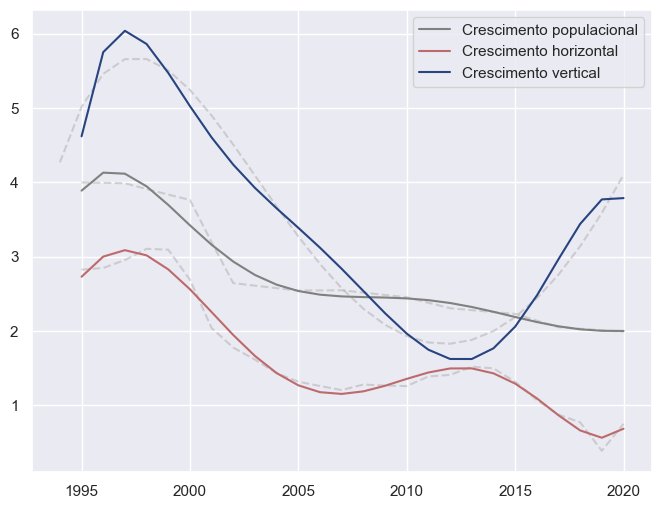

In [157]:
fig, ax = plt.subplots()

plt.plot(tendencia['Unnamed: 0'][1:], f_vert_raw(tendencia['Unnamed: 0'][1:]), color='#AFACAD', linestyle='dashed', alpha=0.5)
plt.plot(tendencia['Unnamed: 0'][1:], tendencia['horz_taxa_crescimento'][1:], color='#AFACAD', linestyle='dashed', alpha=0.5)
plt.plot(tendencia['Unnamed: 0'][1:], tendencia['pop_taxa_crescimento'][1:], color='#AFACAD', linestyle='dashed', alpha=0.5)
plt.plot(tendencia['Unnamed: 0'][2:], f_pop(tendencia['Unnamed: 0'][2:]), color='gray', label='Crescimento populacional')
plt.plot(tendencia['Unnamed: 0'][2:], f_horz(tendencia['Unnamed: 0'][2:]), color='#BD6A6D', label='Crescimento horizontal')
plt.plot(tendencia['Unnamed: 0'][2:], f_vert(tendencia['Unnamed: 0'][2:]), color='#274480', label='Crescimento vertical')
#plt.plot(tendencia['Unnamed: 0'][2:], f_form(tendencia['Unnamed: 0'][2:]), color='#274480', label='Crescimento da forma')


ax.legend()

/Users/guilhermeiablonovski/opt/anaconda3/envs/geopandasenv/lib/python3.7/site-packages/numpy/lib/polynomial.py:658: RuntimeWarning:

overflow encountered in multiply

/Users/guilhermeiablonovski/opt/anaconda3/envs/geopandasenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: RankWarning:

Polyfit may be poorly conditioned

/Users/guilhermeiablonovski/opt/anaconda3/envs/geopandasenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: RankWarning:

Polyfit may be poorly conditioned



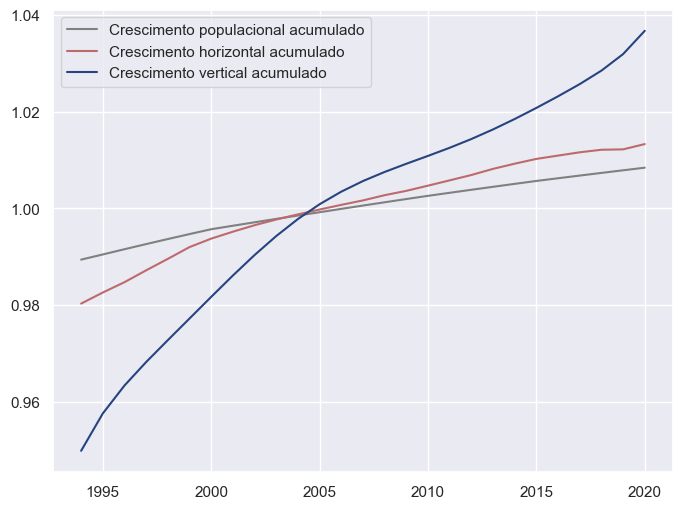

In [158]:
fig, ax = plt.subplots()

coefficients_log_vert = np.polyfit(tendencia['Unnamed: 0'][1:],tendencia['v_log'][1:],90)
f_log_vert = np.poly1d(coefficients_log_vert)

coefficients_log_form = np.polyfit(tendencia['Unnamed: 0'][1:],tendencia['f_log'][1:],90)
f_log_form = np.poly1d(coefficients_log_form)

#plt.plot(tendencia['Unnamed: 0'][1:], f_vert_raw(tendencia['Unnamed: 0'][1:]), color='#AFACAD', linestyle='dashed', alpha=0.5)
#plt.plot(tendencia['Unnamed: 0'][1:], tendencia['horz_taxa_crescimento'][1:], color='#AFACAD', linestyle='dashed', alpha=0.5)
#plt.plot(tendencia['Unnamed: 0'][1:], tendencia['pop_taxa_crescimento'][1:], color='#AFACAD', linestyle='dashed', alpha=0.5)
plt.plot(tendencia['Unnamed: 0'][1:], tendencia['p_log'][1:], color='gray', label='Crescimento populacional acumulado')
plt.plot(tendencia['Unnamed: 0'][1:], tendencia['h_log'][1:], color='#BD6A6D', label='Crescimento horizontal acumulado')
plt.plot(tendencia['Unnamed: 0'][1:], f_log_vert(tendencia['Unnamed: 0'][1:]), color='#274480', label='Crescimento vertical acumulado')
#plt.plot(tendencia['Unnamed: 0'][1:], f_log_form(tendencia['Unnamed: 0'][1:]), color='#274480', label='Crescimento da forma urbana acumulado')


ax.legend()

In [159]:
tendencia_cidade = pd.read_excel('_raw_data/heightzonalstats/citywide_ugi_ogi_pop.xlsx')
tendencia_cidade

_nm_concur  tamanho      urban  urban_2020  h_1993  h_2020  \
0                   Ilhéus  Pequena   0.164371    0.211218   0.116   0.086   
1                Itapipoca  Pequena   0.158994    0.283173   0.102   0.156   
2    Santana do Livramento  Pequena   0.375995    0.459924   0.069   0.088   
3                   Muriaé  Pequena   0.345655    0.488811   0.123   0.147   
4                      Ubá  Pequena   0.232608    0.387553   0.124   0.152   
..                     ...      ...        ...         ...     ...     ...   
176               Brasília   Grande  16.105264   22.516472   5.145   8.733   
177           Porto Alegre   Grande  16.488054   20.557144   4.497   6.369   
178         Belo Horizonte   Grande  20.590999   24.752622   7.454  11.607   
179         Rio de Janeiro   Grande  46.574490   53.080138  12.603  20.956   
180              São Paulo   Grande  62.883133   70.600862  21.222  34.467   

         pop_1993      pop_2020  form_1993  form_2020  ...  razao_pop_horz  \
0    4.217587e+04  2.792204e+04   0.019067   0.018165  ...       -1.185801   
1    2.138484e+04  3.487584e+04   0.016217   0.044175  ...        0.807741   
2    5.671109e+04  4.260415e+04   0.025944   0.040473  ...       -1.114384   
3    3.744278e+04  4.495441e+04   0.042516   0.071855  ...        0.484395   
4    3.086407e+04  4.635619e+04   0.028843   0.058908  ...        0.753535   
..            ...           ...        ...        ...  ...             ...   
176  1.373744e+06  2.895185e+06   1.721805   4.283290  ...        2.782131   
177  2.522935e+06  3.063184e+06   1.997030   3.662294  ...        0.867682   
178  2.819395e+06  4.201804e+06   3.185901   6.493075  ...        2.426026   
179  8.576837e+06  1.111178e+07   5.794847  11.453549  ...        2.115912   
180  1.484447e+07  1.820362e+07  12.932784  25.589020  ...        1.843780   

     razao_pop_vert  razao_pop_form  geom_horz  geom_vert  geom_pop  \
0          1.306785        7.141692   0.009331  -0.011022 -0.015159   
1          1.191639        0.365949   0.021608   0.015861  0.018280   
2         -0.903359       -0.444161   0.007490   0.009049 -0.010537   
3          1.028159        0.290710   0.012917   0.006624  0.006795   
4          2.222907        0.481556   0.019087   0.007569  0.015179   
..              ...             ...        ...        ...       ...   
176        1.588117        0.744461   0.012488   0.019789  0.027996   
177        0.514405        0.256797   0.008203   0.012974  0.007212   
178        0.880052        0.472342   0.006841   0.016537  0.014887   
179        0.445935        0.302667   0.004854   0.019011  0.009637   
180        0.362576        0.231234   0.004297   0.018124  0.007584   

     geom_form  razao_pop_horz_geom  razao_pop_vert_geom  razao_pop_form_geom  
0    -0.001794            -1.624634             1.375371             8.450423  
1     0.037811             0.846017             1.152543             0.483464  
2     0.016607            -1.406793            -1.164447            -0.634499  
3     0.019627             0.526010             1.025820             0.346197  
4     0.026801             0.795260             2.005404             0.566373  
..         ...                  ...                  ...                  ...  
176   0.034330             2.241760             1.414739             0.815508  
177   0.022714             0.879243             0.555922             0.317519  
178   0.026721             2.176181             0.900215             0.557131  
179   0.025556             1.985137             0.506880             0.377081  
180   0.025596             1.765023             0.418448             0.296292  

[181 rows x 24 columns]

/Users/guilhermeiablonovski/opt/anaconda3/envs/geopandasenv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



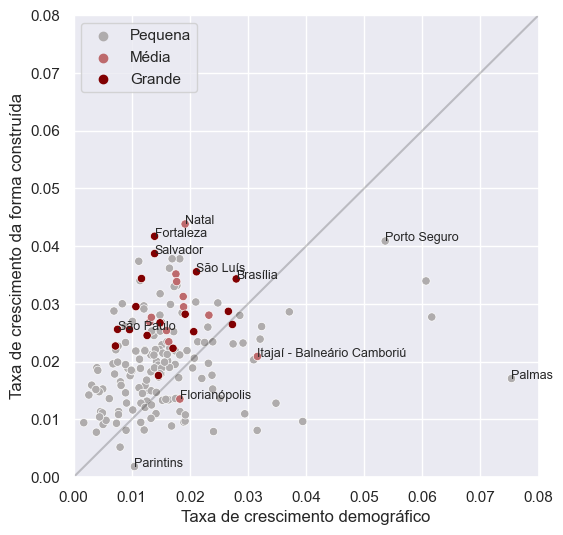

In [166]:
f = plt.figure(figsize=(6,6))
ax = plt.axes()
subset = tendencia_cidade[(tendencia_cidade['geom_form']>0)&(tendencia_cidade['geom_pop']>0)]
sns.scatterplot(subset['geom_pop'],subset['geom_form'], hue=subset['tamanho'], hue_order=['Pequena','Média','Grande'], palette=['#AFACAD','#BD6A6D','#810002'])
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='black',alpha=0.2)
plt.xlim([0, 0.08])
plt.ylim([0,0.08])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[3:], labels=labels)
ax.set_ylabel("Taxa de crescimento da forma construída")
ax.set_xlabel("Taxa de crescimento demográfico")

grandes_subset = subset[(subset['_nm_concur'].isin(['Itajaí - Balneário Camboriú','São Paulo','Natal','Florianópolis','Palmas','Parintins','Fortaleza','Salvador','Brasília','São Luís','Porto Seguro']))]
nomes = grandes_subset['_nm_concur'].to_list()
pops = grandes_subset['geom_pop'].to_list()
razao = grandes_subset['geom_form'].to_list()


for i, cidade in enumerate(nomes):
    plt.annotate(cidade, (pops[i], razao[i]),fontsize=9)



/Users/guilhermeiablonovski/opt/anaconda3/envs/geopandasenv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



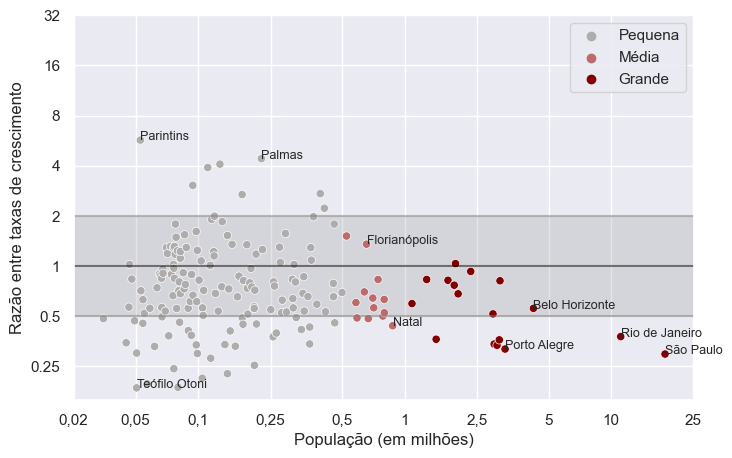

In [171]:
f = plt.figure(figsize=(8,5))
ax = plt.axes()
subset = tendencia_cidade[(tendencia_cidade['razao_pop_form_geom']>0)&(tendencia_cidade['razao_pop_form_geom']<8)]
ax.fill_between([25000,25000000],[2,2],[0.5,0.5], color='gray',alpha=0.2)
plt.xlim([25000,25000000])
plt.axhline(y=1, color='black', alpha=0.5)
plt.axhline(y=0.5, color='gray', alpha=0.5)
plt.axhline(y=2, color='gray', alpha=0.5)
sns.scatterplot(subset['pop_2020'],subset['razao_pop_form_geom'], hue=subset['tamanho'], hue_order=['Pequena','Média','Grande'], palette=['#AFACAD','#BD6A6D','#810002'])
ax.set_xscale("log")
ax.set_yscale('log')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y:g}'))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y:g}'))
ax.yaxis.set_ticks([0.25,0.5,1,2,4,8,16,32])
ax.xaxis.set_ticks([25000,50000,100000,225000,500000,1000000,2250000,5000000,10000000,25000000])
ax.xaxis.set_ticklabels(['0,02','0,05','0,1','0,25','0,5','1','2,5','5','10','25'])
ax.legend(handles=handles[3:], labels=labels)
ax.set_ylabel("Razão entre taxas de crescimento")
ax.set_xlabel("População (em milhões)")

grandes_subset = subset[(subset['_nm_concur'].isin(['São Paulo','Rio de Janeiro','Belo Horizonte','Porto Alegre','Natal','Florianópolis']))|(subset['razao_pop_form_geom']>4.2)|(subset['razao_pop_form_geom']<0.187)]
nomes = grandes_subset['_nm_concur'].to_list()
pops = grandes_subset['pop_2020'].to_list()
razao = grandes_subset['razao_pop_form_geom'].to_list()


for i, cidade in enumerate(nomes):
    plt.annotate(cidade, (pops[i], razao[i]),fontsize=9)




#ax.set_title('Pop x Form',fontsize = 14)